5318 Assignment2 - Group 91

# 1. Set up

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import insightface
from insightface.app import FaceAnalysis
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import scipy
import onnxruntime as ort
import shutil
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.nn import Parameter
import math
import torchvision.datasets as datasets
from torch.nn import DataParallel
from torch.optim.lr_scheduler import StepLR
import time
from sklearn.model_selection import train_test_split
from math import floor
from torchvision import datasets, transforms, models
import timm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import re

/home/xiaoxin/.conda/envs/face/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Data loading, pre-processing, and exploration
The dataset is stored in a 100 folds which contain 400 images. 

This dataset is for Age estimation: Predict the age of individuals in the images using deep learning model, such as resnet18, efficientnet and swin-tiny.

## 2.1 Data loading

### Data ingestion function definition

In [3]:
# Load image
def load_image(image_path):
    img = cv2.imread(image_path, 1)
    if img is None:
        return None
    else:
        return img

# Get image paths from image folder
def get_image_paths(image_folder):
    image_paths = list()
    for root, dirs, files in os.walk(image_folder):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))
    return image_paths

# Image path combination
def get_image_paths_from_df(image_folder, paths):
    image_paths_filter = (image_folder + paths).tolist()
    return image_paths_filter

# Display image
def image_show(images_paths):
    images = [load_image(img_path) for img_path in images_paths[0:30]]
    plt.figure(figsize=(15, 10))
    for i in range(min(30, len(images_paths))):
        plt.subplot(6, 5, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)) 
        plt.axis('off')
    plt.show()

### Load images

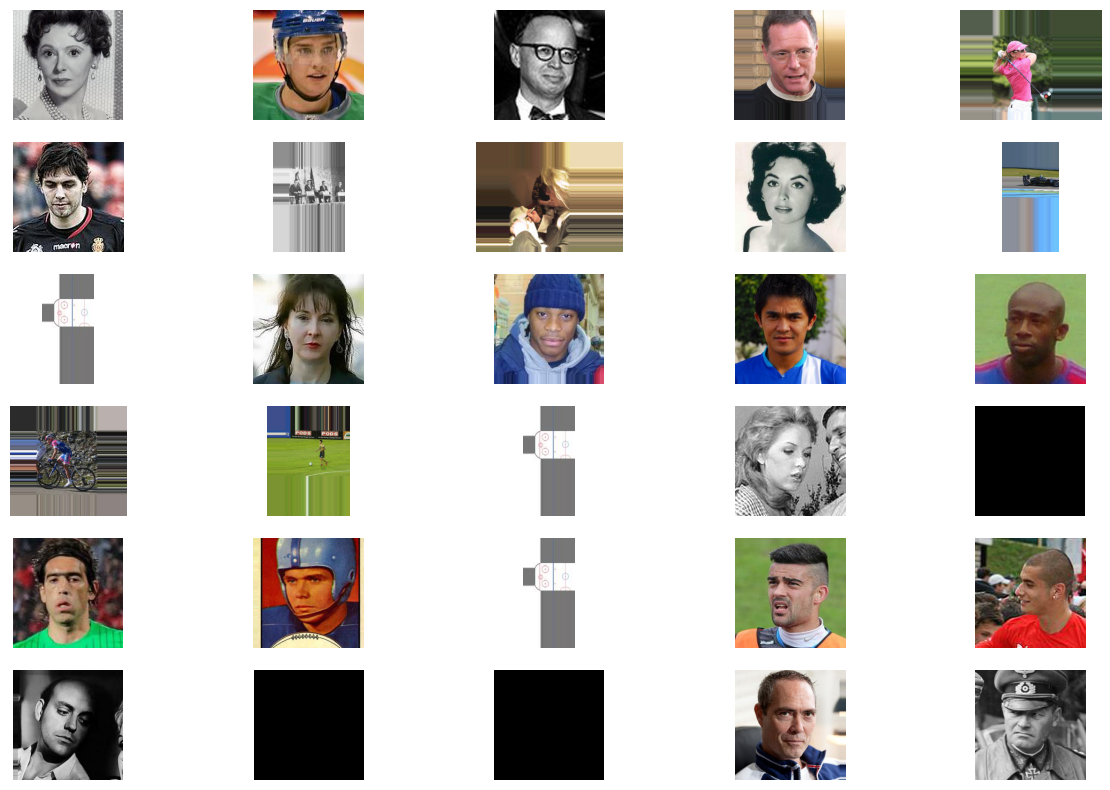

In [4]:
image_folder = 'Wiki_Face_Small/wiki_face_small'

# Get whole paths of all images
image_paths = get_image_paths(image_folder)
            
# Display top 30 images
image_show(image_paths)

## 2.2 Exploration and data pre-processing (data cleaning)

1. In this part, we used insightface.app to detect images which not include any faces.
2. After cleaning the data through pretrained model, we used mat file to clean the data again.

### 2.2.1 Use insightface.app to filter vaild data

#### Data cleaning functions definition

In [5]:
# Detecting Faces
def detect_faces(img, app):
    if img is None or not isinstance(img, np.ndarray):
        print("Invalid image encountered.")
        return False 

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    try:
        faces = app.get(img_rgb)
        return len(faces) > 0
    except Exception as e:
        print(f"Error processing image: {e}")
        return False

# Calculate ages and motify path
def calculate_ages(img_path):
    segments = img_path.replace('\\', '/').split('/')
    last_two_segments = segments[-2] + '/' + segments[-1].split('.')[0] 

    # calculate age
    file_name = segments[-1]
    birth_date_str = file_name.split('_')[1]
    birth_year = int(birth_date_str.split('-')[0])

    last_year_str = file_name.split('_')[-1].split('.')[0] 
    last_year = int(last_year_str)
    age = last_year - birth_year

    return age, f"{last_two_segments}.jpg"

# Check folder
def make_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

#### Device check

In [6]:
# Check CUDA environment
if torch.cuda.is_available() and len(ort.get_available_providers()) == 3:
    print("CUDA is available.")
else:
    print("CUDA is not available.")

CUDA is available.


#### Use FaceAnalysis to detect faces and filter valid data

In [103]:
# Initial model
app = FaceAnalysis(allowed_modules=['detection', 'recognition'], det_thresh=0.2, recog_thresh=0.2, model='antelope', providers=['CUDAExecutionProvider'])
app.prepare(ctx_id=0, det_size=(480, 480))

# Check folder
main_folders = ['Wiki_Face_Small_Cleaned', 'Wiki_Face_Small_Noise']
for main_folder in main_folders:
    for i in range(100):
        sub_folder = f"{i:02d}"
        full_path = os.path.join(main_folder, sub_folder)
        make_folder(full_path)

# Detect images and save in the folders
for img_path in tqdm(image_paths, desc="Detecting Faces:"):
    img = load_image(img_path)
    has_face = detect_faces(img, app)
    age, path = calculate_ages(img_path)
    if has_face:
        cv2.imwrite("Wiki_Face_Small_Cleaned/" + path, img)
    else:
        cv2.imwrite("Wiki_Face_Small_Noise/" + path, img)

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
model ignore: /home/xiaoxin/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAE

Detecting Faces:: 100%|██████████████████| 40000/40000 [05:40<00:00, 117.46it/s]


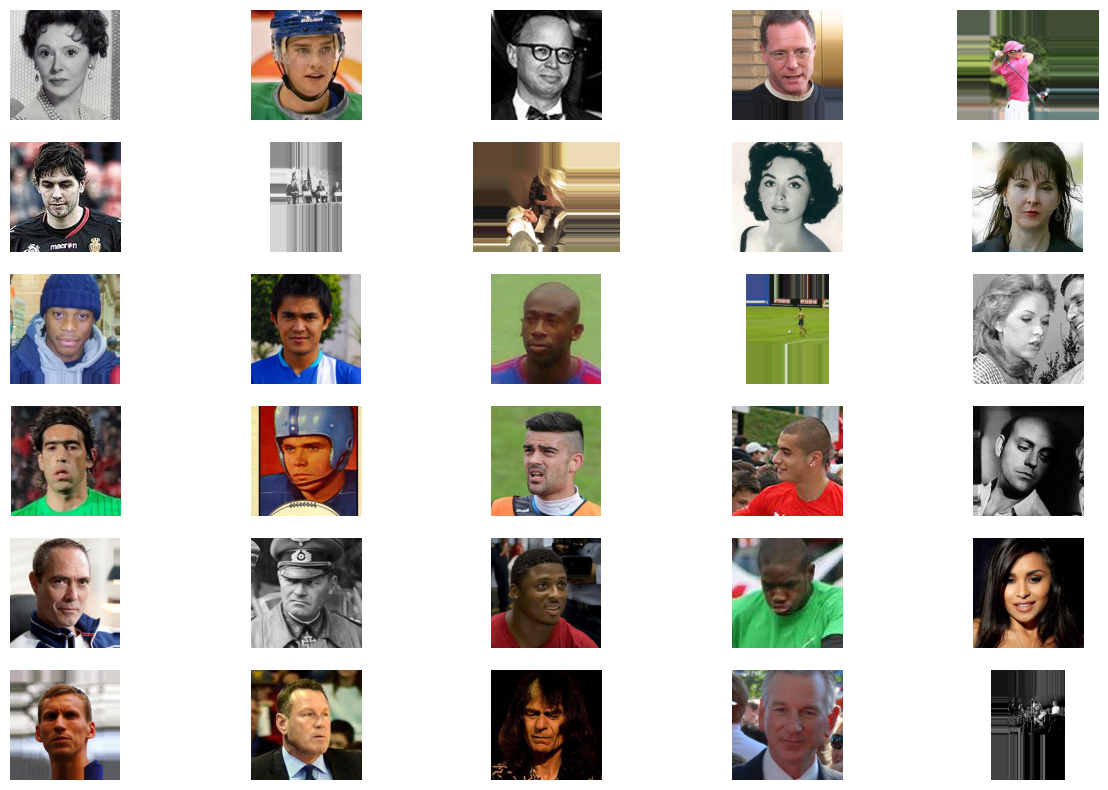

In [7]:
# Display top 30 cleaned images
clean_image_paths = get_image_paths("Wiki_Face_Small_Cleaned")
image_show(clean_image_paths)

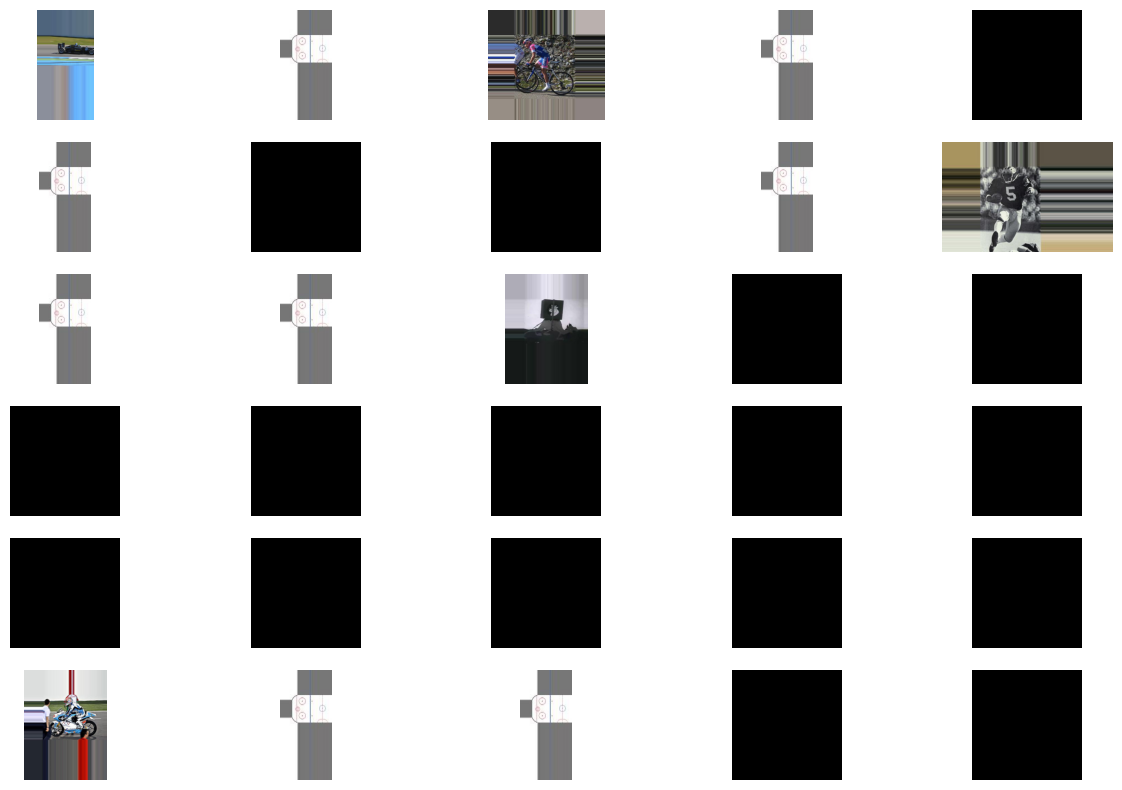

In [8]:
# Display top 30 noisy images
noisy_image_paths = get_image_paths("Wiki_Face_Small_Noise")
image_show(noisy_image_paths)

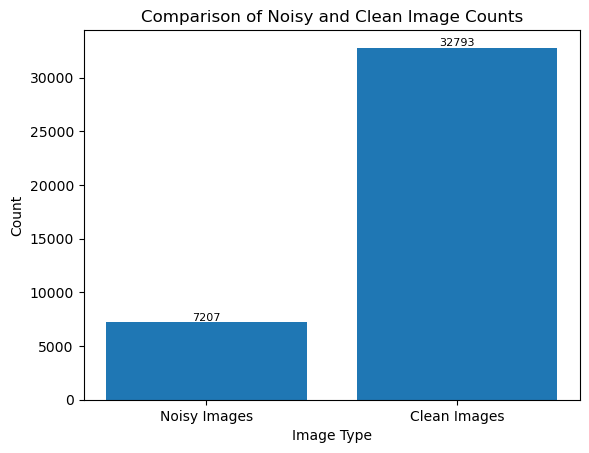

In [9]:
# Visualization
def display_counts_after_cleaning(clean_image_paths, noisy_image_paths, title):
    noisy_count = len(noisy_image_paths)
    clean_count = len(clean_image_paths)
    
    labels = ['Noisy Images', 'Clean Images']
    counts = [noisy_count, clean_count]
    
    bars = plt.bar(labels, counts)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom', fontsize=8)

    plt.title(title)
    plt.xlabel('Image Type')
    plt.ylabel('Count')
    
    plt.show()
    
display_counts_after_cleaning(clean_image_paths, noisy_image_paths, 'Comparison of Noisy and Clean Image Counts')

### 2.2.2 Use mat file to filter vaild data again

#### Load mat data and display information

In [10]:
mat_data = scipy.io.loadmat('Wiki_Face_Small/wiki_face_small/wiki_face_small.mat')

In [11]:
print(mat_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'wiki'])


In [12]:
print("Type   of 'wiki' data:", type(mat_data['wiki']))
print("Dtype  of 'wiki' data:", mat_data['wiki'].dtype)
print("Shape  of 'wiki' data:", mat_data['wiki'].shape)
print("Number of dimensions (ndim) of 'wiki' data:", mat_data['wiki'].ndim)
print("Field names of 'wiki' data:", list(mat_data['wiki'].dtype.names))

Type   of 'wiki' data: <class 'numpy.ndarray'>
Dtype  of 'wiki' data: [('dob', 'O'), ('photo_taken', 'O'), ('full_path', 'O'), ('gender', 'O'), ('name', 'O'), ('face_location', 'O'), ('face_score', 'O'), ('second_face_score', 'O'), ('age', 'O')]
Shape  of 'wiki' data: (1, 1)
Number of dimensions (ndim) of 'wiki' data: 2
Field names of 'wiki' data: ['dob', 'photo_taken', 'full_path', 'gender', 'name', 'face_location', 'face_score', 'second_face_score', 'age']


#### Convert to dataframe

In [13]:
#Unpack the data from matlab format data file
data = mat_data['wiki'][0][0]
dob = data[0][0]
photo_taken = data[1][0]
full_path = data[2][0]
gender = data[3][0]
name = data[4][0]
face_location = data[5][0]
face_score = data[6][0]
second_face_score = data[7][0]
age = data[8][0]
#Build a dictionary for pd
wiki_dict = {
    'dob': dob,
    'photo_taken': photo_taken,
    'full_path': full_path,
    'gender': gender,
    'name': name,
    'face_score': face_score,
    'second_face_score': second_face_score,
    'age': age
}
wiki = pd.DataFrame(wiki_dict)
wiki['full_path'] = wiki['full_path'].apply(lambda x: x[0])
wiki.head()

dob  photo_taken                        full_path  gender  \
0  712934         2012   27/5137227_1951-12-12_2012.jpg     1.0   
1  725616         2011  68/22983068_1986-09-01_2011.jpg     1.0   
2  722957         2004  09/10801009_1979-05-22_2004.jpg     1.0   
3  706373         1964   15/7775715_1933-12-25_1964.jpg     1.0   
4  725707         2014   19/8679319_1986-12-01_2014.jpg     1.0   

                name  face_score  second_face_score  age  
0   [Tim McClelland]    2.209695                NaN   60  
1  [Antonio Coleman]        -inf                NaN   24  
2  [Alexei Beletski]    4.954108                NaN   24  
3    [Basil Heatley]    2.480820           1.952827   30  
4   [DeSean Jackson]    4.163307                NaN   27

#### Labels distribution analysis

In [14]:
sns.boxplot(x=wiki['age'].dropna())
plt.title('Boxplot of Age in wiki dataset')
plt.xlabel('Age')
plt.show()

#### Data cleaning with special conditions
1. age >= 0 and <= 130
2. second_face_score < 8 or == None

In [15]:
clean_image_paths = get_image_paths("Wiki_Face_Small_Cleaned")
def transform_image_paths(path):
    path = path.replace('Wiki_Face_Small_Cleaned\\', '').replace('\\', '/')
    return path

clean_image_paths = pd.Series(clean_image_paths).apply(transform_image_paths)
clean_image_paths = clean_image_paths.tolist()
print('Format of clean_image_paths:', clean_image_paths[0])

Format of clean_image_paths: 00/10049200_1891-09-16_1958.jpg


In [16]:
face_cleaned_wiki = wiki[wiki['full_path'].isin(clean_image_paths)]

In [17]:
double_cleaned_wiki = face_cleaned_wiki[(face_cleaned_wiki['age'] >= 0) & (face_cleaned_wiki['age'] <= 130)
                        & ((face_cleaned_wiki['second_face_score'] < 8) | (face_cleaned_wiki['second_face_score'].isna()))]
double_cleaned_wiki = double_cleaned_wiki.reset_index(drop=True)

In [18]:
double_cleaned_wiki.loc[double_cleaned_wiki['gender'].isna(), 'gender'] = -1
print(len(double_cleaned_wiki[double_cleaned_wiki['gender'] == -1]))
double_cleaned_wiki.loc[double_cleaned_wiki['face_score'] == -np.inf, 'face_score'] = -100
print(len(double_cleaned_wiki[double_cleaned_wiki['face_score'] == -100]))
double_cleaned_wiki.loc[double_cleaned_wiki['second_face_score'].isna(), 'second_face_score'] = -100
print(len(double_cleaned_wiki[double_cleaned_wiki['second_face_score'] == -100]))

659
4413
30112


#### Display age distribution after cleaning

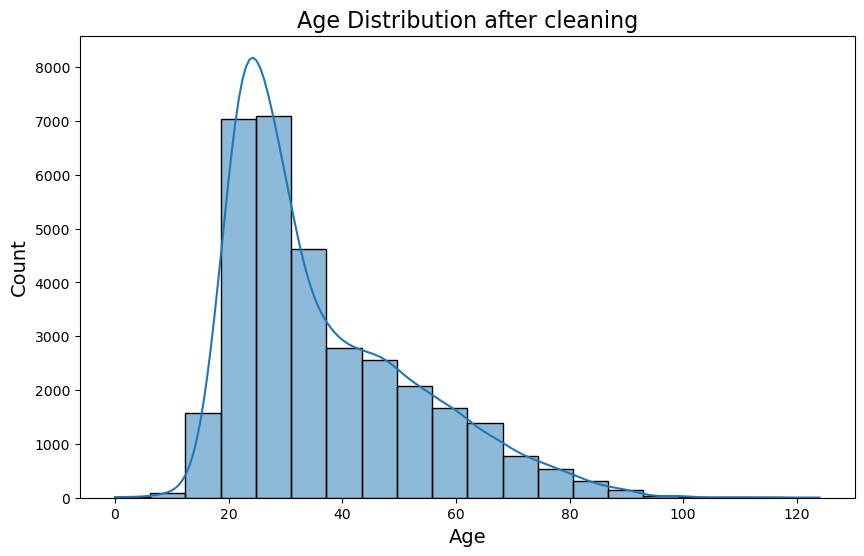

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(double_cleaned_wiki['age'].dropna(), bins=20, kde=True)

plt.title('Age Distribution after cleaning', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.show()

#### Display clean data and noise data after double cleaning

In [20]:
double_throwed_wiki = face_cleaned_wiki[~face_cleaned_wiki['full_path'].isin(double_cleaned_wiki['full_path'])]

In [21]:
double_cleaned_paths = get_image_paths_from_df('Wiki_Face_Small_Cleaned/', double_cleaned_wiki['full_path'])
double_throwed_paths = get_image_paths_from_df('Wiki_Face_Small_Cleaned/', double_throwed_wiki['full_path'])

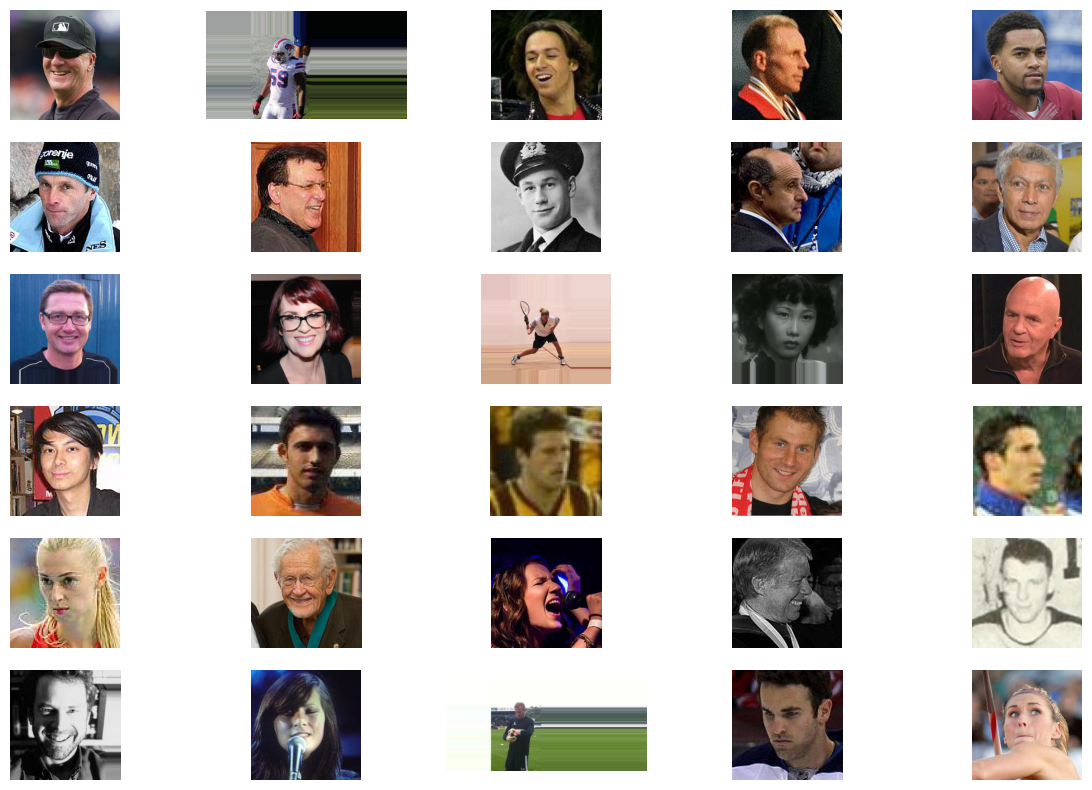

In [22]:
image_show(double_cleaned_paths)

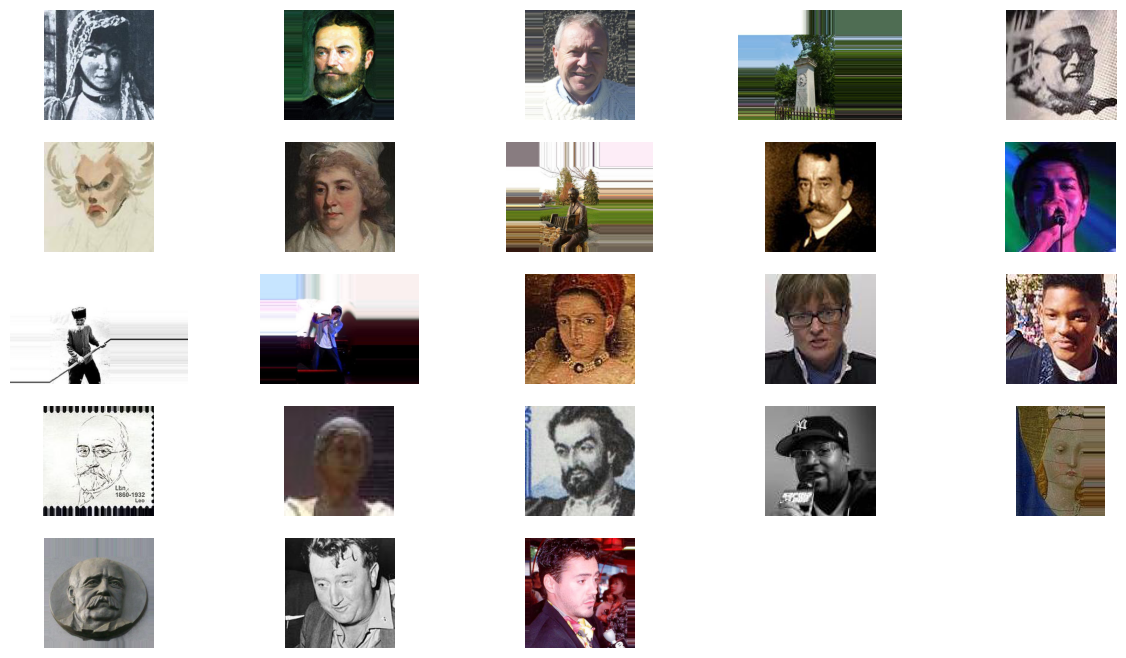

In [23]:
image_show(double_throwed_paths)

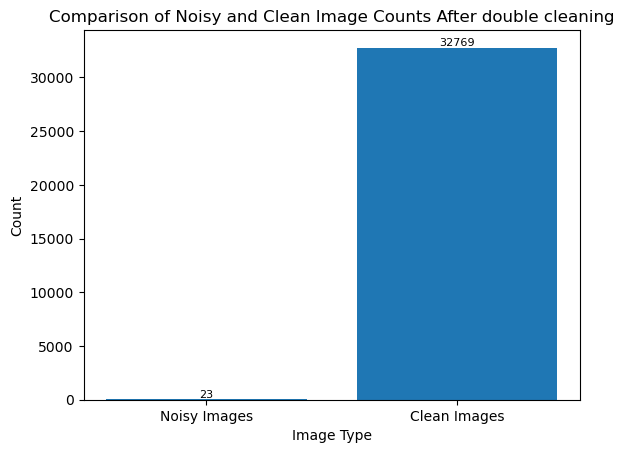

In [24]:
display_counts_after_cleaning(double_cleaned_paths, double_throwed_paths,
                              'Comparison of Noisy and Clean Image Counts After double cleaning')

## 2.3 Data exploration again after data cleaning

### Invalid value exploration

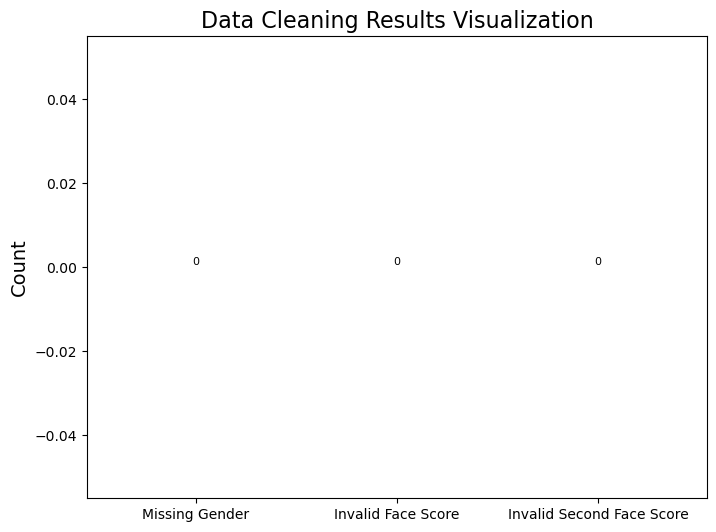

In [25]:
def visualize_invalid_value(df):
    gender_missing_count = len(df.loc[double_cleaned_wiki['gender'].isna(), 'gender'])
    face_score_invalid_count = len(df.loc[double_cleaned_wiki['face_score'] == -np.inf, 'face_score'])
    second_face_score_invalid_count = len(df.loc[double_cleaned_wiki['second_face_score'].isna(), 'second_face_score'])
    
    labels = ['Missing Gender', 'Invalid Face Score', 'Invalid Second Face Score']
    counts = [gender_missing_count, face_score_invalid_count, second_face_score_invalid_count]
    
    plt.figure(figsize=(8, 6))
    bars = plt.bar(labels, counts)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom', fontsize=8)

    plt.title('Data Cleaning Results Visualization', fontsize=16)
    plt.ylabel('Count', fontsize=14)
    
    plt.show()

visualize_invalid_value(double_cleaned_wiki)

### Distributions of attributes

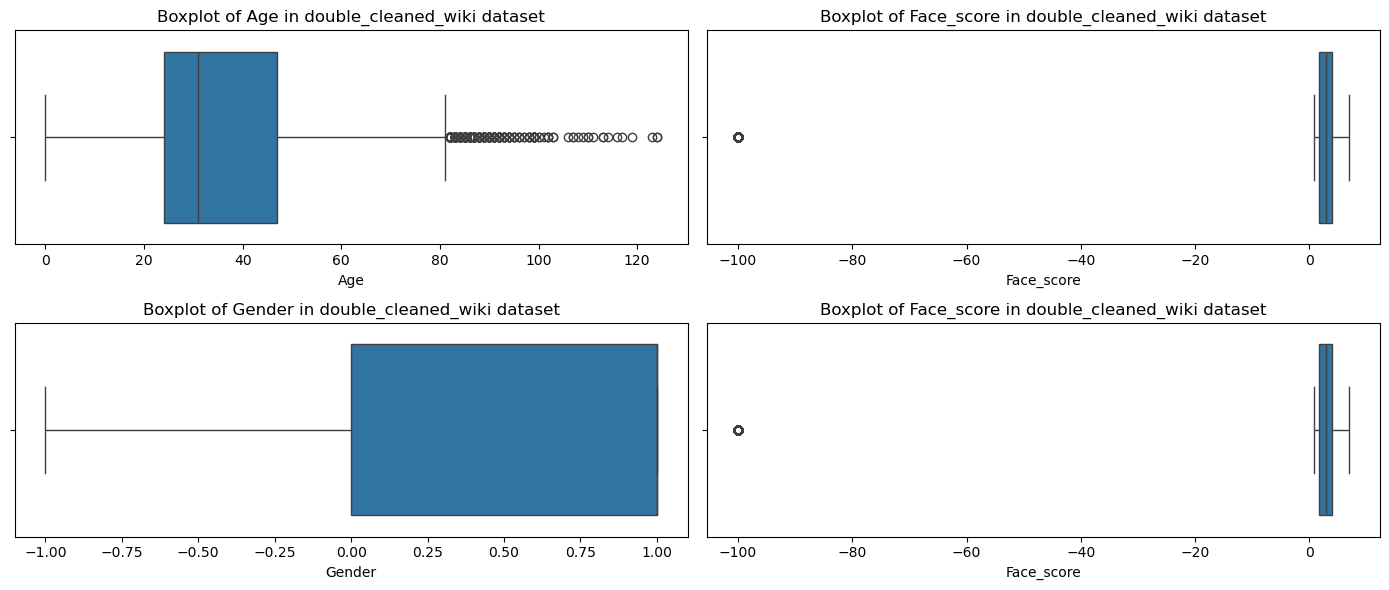

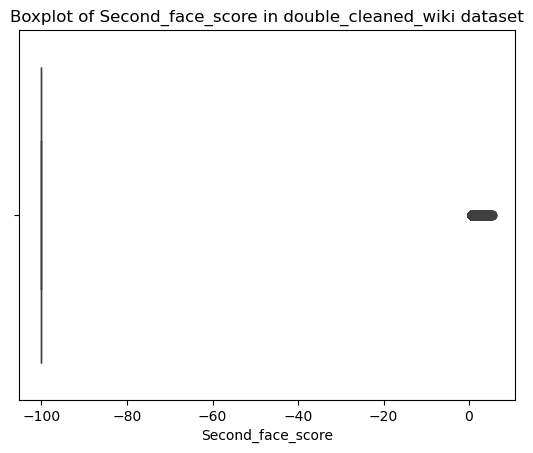

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(14, 6))

sns.boxplot(x=double_cleaned_wiki['age'].dropna(), ax=axes[0][0])
axes[0][0].set_title('Boxplot of Age in double_cleaned_wiki dataset')
axes[0][0].set_xlabel('Age')

sns.boxplot(x=double_cleaned_wiki['face_score'].replace(-np.inf, np.nan).dropna(), ax=axes[0][1])
axes[0][1].set_title('Boxplot of Face_score in double_cleaned_wiki dataset')
axes[0][1].set_xlabel('Face_score')

sns.boxplot(x=double_cleaned_wiki['gender'].dropna(), ax=axes[1][0])
axes[1][0].set_title('Boxplot of Gender in double_cleaned_wiki dataset')
axes[1][0].set_xlabel('Gender')

sns.boxplot(x=double_cleaned_wiki['face_score'].replace(-np.inf, np.nan).dropna(), ax=axes[1][1])
axes[1][1].set_title('Boxplot of Face_score in double_cleaned_wiki dataset')
axes[1][1].set_xlabel('Face_score')
plt.tight_layout()
plt.show()

sns.boxplot(x=double_cleaned_wiki['second_face_score'])
plt.title('Boxplot of Second_face_score in double_cleaned_wiki dataset')
plt.xlabel('Second_face_score')
plt.show()


In [28]:
max(double_cleaned_wiki['second_face_score'])
min(double_cleaned_wiki['second_face_score'])
sfs_Q1 = np.percentile(double_cleaned_wiki['second_face_score'].dropna(), 25)
sfs_Q3 = np.percentile(double_cleaned_wiki['second_face_score'].dropna(), 75)
sfs_IQR = sfs_Q3 - sfs_Q1

#outlier boundaries
sfs_lower_bound = sfs_Q1 - 1.5 * sfs_IQR
sfs_upper_bound = sfs_Q3 + 1.5 * sfs_IQR
print(f"Lower bound: {sfs_lower_bound}")
print(f"Upper bound: {sfs_upper_bound}")

Lower bound: -100.0
Upper bound: -100.0


## 2.4 Data preprocessing: calculate ages, split train dataset and test dataset  

### Calculate ages

In [27]:
output_folder = "Age_Folder"
make_folder(output_folder)
for path in tqdm(double_cleaned_paths, desc="Age Processing"):
    relative_path = path.replace("Wiki_Face_Small_Cleaned/", "")
    
    matched_row = double_cleaned_wiki[double_cleaned_wiki['full_path'] == relative_path]

    if not matched_row.empty:
        age = matched_row['age'].values[0]
        
        age_folder = os.path.join(output_folder, str(age))
        make_folder(age_folder)
        
        source_file = path 
        destination_file = os.path.join(age_folder, os.path.basename(path))
        shutil.copy(source_file, destination_file)

Age Processing: 100%|███████████████████████████████████████████████████████████| 32769/32769 [01:15<00:00, 432.58it/s]


### Remove categories that are too small
Remove categories that are too small to divide the appropriate test set and that can not fully learn age-appropriate features.

In [29]:
def delete_folders_with_few_images(main_folders, min_image_count=10):
    image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')

    for main_folder in main_folders:
        print(f"Processing main folder: {main_folder}")
        
        for root, dirs, files in os.walk(main_folder):
            image_count = sum(1 for file in files if file.lower().endswith(image_extensions))

            if image_count < min_image_count and root != main_folder:  
                print(f"Deleting folder: {root}, it contains {image_count} images")
                shutil.rmtree(root) 

In [29]:
delete_folders_with_few_images([output_folder], min_image_count=10)

Processing main folder: Age_Folder
Deleting folder: Age_Folder\0, it contains 6 images
Deleting folder: Age_Folder\1, it contains 1 images
Deleting folder: Age_Folder\100, it contains 2 images
Deleting folder: Age_Folder\101, it contains 1 images
Deleting folder: Age_Folder\102, it contains 3 images
Deleting folder: Age_Folder\103, it contains 2 images
Deleting folder: Age_Folder\106, it contains 1 images
Deleting folder: Age_Folder\107, it contains 2 images
Deleting folder: Age_Folder\108, it contains 1 images
Deleting folder: Age_Folder\109, it contains 1 images
Deleting folder: Age_Folder\110, it contains 2 images
Deleting folder: Age_Folder\111, it contains 1 images
Deleting folder: Age_Folder\113, it contains 2 images
Deleting folder: Age_Folder\114, it contains 1 images
Deleting folder: Age_Folder\116, it contains 1 images
Deleting folder: Age_Folder\117, it contains 1 images
Deleting folder: Age_Folder\119, it contains 1 images
Deleting folder: Age_Folder\123, it contains 1 imag

### Load dataset and split test dataset and train dataset

In [30]:
random_seed = 42
random.seed(random_seed)

image_dir = "./Age_Folder"
train_dir = "./train_set"
test_dir = "./test_set"
val_dir = './val_set'

In [31]:
make_folder(train_dir)
make_folder(test_dir)

# Create train_set, test_set and validation set
for age_folder in os.listdir(image_dir):
    age_path = os.path.join(image_dir, age_folder)

    # Make sure every age folder use the same proportion to split
    if os.path.isdir(age_path):
        images = [img for img in os.listdir(age_path) if img.endswith(('.jpg', '.png', '.jpeg'))]
        random.shuffle(images)
        num_samples = len(images)
        num_train_samples = floor(0.8 * num_samples)
        num_val_samples = floor(0.1 * num_samples)
        num_test_samples = num_samples - num_train_samples - num_val_samples
        
        train_imgs = images[:num_train_samples]
        val_imgs = images[num_train_samples:num_train_samples + num_val_samples]
        test_imgs = images[num_train_samples + num_val_samples:]
        
        make_folder(os.path.join(train_dir, age_folder))
        make_folder(os.path.join(test_dir, age_folder))
        make_folder(os.path.join(val_dir, age_folder))

        for img in train_imgs:
            shutil.copy(os.path.join(age_path, img), os.path.join(train_dir, age_folder, img))
            
        for img in val_imgs:
            shutil.copy(os.path.join(age_path, img), os.path.join(val_dir, age_folder, img))
        
        for img in test_imgs:
            shutil.copy(os.path.join(age_path, img), os.path.join(test_dir, age_folder, img))

In [31]:
double_cleaned_wiki['full_path'] = double_cleaned_wiki['full_path'].apply(lambda x: 'Wiki_Face_Small_Cleaned\\' + x)
double_cleaned_wiki

dob  photo_taken                                          full_path  \
0      712934         2012  Wiki_Face_Small_Cleaned\27/5137227_1951-12-12_...   
1      725616         2011  Wiki_Face_Small_Cleaned\68/22983068_1986-09-01...   
2      722957         2004  Wiki_Face_Small_Cleaned\09/10801009_1979-05-22...   
3      706373         1964  Wiki_Face_Small_Cleaned\15/7775715_1933-12-25_...   
4      725707         2014  Wiki_Face_Small_Cleaned\19/8679319_1986-12-01_...   
...       ...          ...                                                ...   
32764  725690         2015  Wiki_Face_Small_Cleaned\74/42456374_1986-11-14...   
32765  715408         2011  Wiki_Face_Small_Cleaned\65/3354265_1958-09-20_...   
32766  723292         2013  Wiki_Face_Small_Cleaned\12/42209512_1980-04-21...   
32767  727788         2011  Wiki_Face_Small_Cleaned\25/34014025_1992-08-12...   
32768  726413         2014  Wiki_Face_Small_Cleaned\61/36534961_1988-11-06...   

       gender                  name  face_score  second_face_score  age  
0         1.0      [Tim McClelland]    2.209695        -100.000000   60  
1         1.0     [Antonio Coleman] -100.000000        -100.000000   24  
2         1.0     [Alexei Beletski]    4.954108        -100.000000   24  
3         1.0       [Basil Heatley]    2.480820           1.952827   30  
4         1.0      [DeSean Jackson]    4.163307        -100.000000   27  
...       ...                   ...         ...                ...  ...  
32764     1.0  [Cory Michael Smith]    3.986726        -100.000000   28  
32765     1.0       [Norbert Meier]    2.972500        -100.000000   52  
32766     0.0   [Rebecca Zlotowski]    3.559609        -100.000000   32  
32767     1.0       [Conor McAleny]    3.430896        -100.000000   18  
32768     0.0      [Conchita Wurst]    3.024268        -100.000000   25  

[32769 rows x 8 columns]

In [32]:
zeni_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=540367825)

#First split
zeni_train_val_df, zeni_test_df = train_test_split(double_cleaned_wiki, test_size = 0.2, random_state = 540367825, stratify = double_cleaned_wiki['gender'])

#split train+val into train and validation
zeni_train_df, zeni_val_df = train_test_split(zeni_train_val_df, test_size = 0.25, random_state = 540367825, stratify = zeni_train_val_df['gender'])

# create a Dataset from dataframe
from Image_Dataset_From_Df import Image_Dataset_From_Df
#class Image_Dataset_From_Df(Dataset):
#    def __init__(self, dataframe, image_column, label_column, transform = None):
#        self.dataframe = dataframe
#        self.image_column = image_column
#        self.label_column = label_column
#        self.transform = transform
#
#    def __len__(self):
#        return len(self.dataframe)
#
#    def __getitem__(self, idx):
#        img_path = self.dataframe.iloc[idx][self.image_column]
#        label = self.dataframe.iloc[idx][self.label_column]
#        #Open the image and apply transformations
#        image = Image.open(img_path).convert('RGB')
#        if self.transform:
#            image = self.transform(image)
#        return image, label
    

### Create DataSet

In [34]:
#initialize the transform, the dataset and train_loader
zeni_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
zeni_dataset = Image_Dataset_From_Df(dataframe = double_cleaned_wiki, image_column = 'full_path', label_column = 'age', transform = zeni_transform)
zeni_train_loader = DataLoader(zeni_dataset, batch_size = 64, shuffle = True, num_workers = 4)

#Initialize variables to compute mean and std
zeni_mean = torch.zeros(3)
zeni_std = torch.zeros(3)
zeni_n_samples = 0

#compute the sum of means and std
for images, labels in zeni_train_loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    zeni_mean += images.mean(2).sum(0)
    zeni_std += images.std(2).sum(0)
    zeni_n_samples += batch_samples

#Final mean and std
zeni_mean /= zeni_n_samples
zeni_std /= zeni_n_samples

print(f'Mean: {zeni_mean}')
print(f'Standard Deviation: {zeni_std}')



Mean: tensor([0.4732, 0.4151, 0.3826])
Standard Deviation: tensor([0.2507, 0.2310, 0.2261])


In [33]:
#preprocessing
zeni_preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.4732, 0.4151, 0.3826], std = [0.2507, 0.2310, 0.2261])
])

train_dataset = Image_Dataset_From_Df(zeni_train_df, image_column = 'full_path', label_column = 'age', transform = zeni_preprocess)
val_dataset = Image_Dataset_From_Df(zeni_val_df, image_column = 'full_path', label_column = 'age', transform = zeni_preprocess)
test_dataset = Image_Dataset_From_Df(zeni_test_df, image_column = 'full_path', label_column = 'age', transform = zeni_preprocess)

#### Calculate mean and std in order to normalize data

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 3. Model Implementation

## Define save function

In [35]:
def save(epoch, model, optimizer, best_params, best_loss, training_time, last_val_loss, checkpoint_name):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best params:': best_params,
            'best loss': best_loss,
            'training time': training_time,
            'last val loss': last_val_loss,
        }, checkpoint_name + '.pth')

## Define training function

In [36]:
def training_model(model, device, optimizer_name, lr, epochs, train_dataset, val_dataset, test_dataset, batch_size, checkpoint = None, checkpoint_name = None):
    model.to(device)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 6)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers = 6)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers = 6)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr) # default
    
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=lr)
        
    start = time.time()
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        all_train_outputs = []  # To store all outputs
        all_train_labels = []   # To store all labels
        
        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.to(device).float().view(-1, 1)

            #zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass: compute predicted ages by passing image to the model
            outputs = model(images)

            # Calculate the loss(MSE)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            
            loss.backward()
            optimizer.step()
    
            all_train_outputs.append(outputs.cpu().detach().numpy())
            all_train_labels.append(labels.cpu().detach().numpy())
    
        average_batch_train_loss = train_loss / len(train_dataloader)
        all_train_outputs = np.concatenate(all_train_outputs)
        all_train_labels = np.concatenate(all_train_labels)
    
        train_mse = np.mean((all_train_outputs - all_train_labels) ** 2)  # Calculate MSE for the entire training set

        model.eval()
        val_loss = 0
        all_val_outputs = []  # To store all outputs
        all_val_labels = []   # To store all labels
        
        with torch.no_grad():
            for images, labels in val_dataloader:
                images = images.to(device)
                labels = labels.to(device).float().view(-1, 1)
    
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                all_val_outputs.append(outputs.cpu().detach().numpy())
                all_val_labels.append(labels.cpu().detach().numpy())
    
        average_batch_val_loss = val_loss / len(val_dataloader)
        all_val_outputs = np.concatenate(all_val_outputs)
        all_val_labels = np.concatenate(all_val_labels)
        val_mse = np.mean((all_val_outputs - all_val_labels) ** 2)  # Calculate MSE for the entire val set  
        time_str = time.asctime(time.localtime(time.time()))
        print(f'{time_str}, Epoch [{epoch + 1}/{epochs}], Train MSE: {train_mse:.4f}, Average batch train mse: {average_batch_train_loss:.4f}, Val MSE: {val_mse:.4f}, Average batch Val loss: {average_batch_val_loss:.4f}')
        start = time.time()

        
    model.eval()
    test_loss = 0
    all_test_outputs = []  # To store all outputs
    all_test_labels = []   # To store all labels
    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device).float().view(-1, 1)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            all_test_outputs.append(outputs.cpu().detach().numpy())
            all_test_labels.append(labels.cpu().detach().numpy())
        average_batch_test_loss = test_loss / len(test_dataloader)
        all_test_outputs = np.concatenate(all_test_outputs)
        all_test_labels = np.concatenate(all_test_labels)
        test_mse = np.mean((all_test_outputs - all_test_labels) ** 2)  # Calculate MSE for the entire test set  
        time_str = time.asctime(time.localtime(time.time()))
        print(f'{time_str}, Epoch [{epoch + 1}/{epochs}], Train MSE: {train_mse:.4f}, Average batch train mse: {average_batch_train_loss:.4f}, Test MSE: {test_mse:.4f}, Average batch Test loss: {average_batch_test_loss:.4f}')
    params = {'epochs': epoch, 'learning_rate': lr, 'batch_size': batch_size,
                                           'optimizer': optimizer_name}
    training_time = time.time() - start
    save(params['epochs'], best_model, optimizer, params, test_mse, training_time, test_mse, checkpoint_name)

## 3.1 Model 1: EfficientNet

In [37]:
class EfficientNet(nn.Module):
    def __init__(self):
        super(EfficientNet, self).__init__()
        self.efficientnet = models.efficientnet_b0(weights=None)

        self.efficientnet.classifier[1] = nn.Linear(
            in_features=self.efficientnet.classifier[1].in_features,out_features=1)

    def forward(self, x):
        return self.efficientnet(x)

In [40]:
efficientModel = EfficientNet()
training_model(efficientModel, device, 'Adam', 0.001, 20, train_dataset, val_dataset, test_dataset, 128)


Mon Oct 14 04:06:43 2024, Epoch [1/20], Train MSE: 604.3596, Average batch train mse: 603.6266, Val MSE: 260.5383, Average batch Val loss: 263.4427
Mon Oct 14 04:07:29 2024, Epoch [2/20], Train MSE: 237.5758, Average batch train mse: 237.5671, Val MSE: 212.8524, Average batch Val loss: 214.2836
Mon Oct 14 04:08:14 2024, Epoch [3/20], Train MSE: 202.1823, Average batch train mse: 202.3077, Val MSE: 188.1750, Average batch Val loss: 190.2265
Mon Oct 14 04:09:01 2024, Epoch [4/20], Train MSE: 177.0219, Average batch train mse: 176.9184, Val MSE: 176.4637, Average batch Val loss: 178.5422
Mon Oct 14 04:09:47 2024, Epoch [5/20], Train MSE: 159.4559, Average batch train mse: 159.4488, Val MSE: 160.7793, Average batch Val loss: 161.6823
Mon Oct 14 04:10:33 2024, Epoch [6/20], Train MSE: 147.3686, Average batch train mse: 147.3275, Val MSE: 160.2344, Average batch Val loss: 160.4678
Mon Oct 14 04:11:20 2024, Epoch [7/20], Train MSE: 136.4146, Average batch train mse: 136.3061, Val MSE: 163.848

## 3.2 Model 2: ResNet18

In [38]:
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.resnet = models.resnet18(weights=None)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 1)

    def forward(self, x):
        return self.resnet(x)

In [48]:
resnetModel = ResNet18()
training_model(resnetModel, device, 'Adam', 0.001, 20, train_dataset, val_dataset, test_dataset, 512)

Mon Oct 14 04:25:11 2024, Epoch [1/20], Train MSE: 751.1332, Average batch train mse: 743.8762, Val MSE: 318.3182, Average batch Val loss: 318.0082
Mon Oct 14 04:25:52 2024, Epoch [2/20], Train MSE: 229.5426, Average batch train mse: 229.1841, Val MSE: 218.1235, Average batch Val loss: 217.9754
Mon Oct 14 04:26:32 2024, Epoch [3/20], Train MSE: 190.3164, Average batch train mse: 189.9536, Val MSE: 225.9567, Average batch Val loss: 225.8157
Mon Oct 14 04:27:12 2024, Epoch [4/20], Train MSE: 175.5494, Average batch train mse: 175.2832, Val MSE: 175.9475, Average batch Val loss: 175.8635
Mon Oct 14 04:27:53 2024, Epoch [5/20], Train MSE: 164.2854, Average batch train mse: 163.6801, Val MSE: 451.0480, Average batch Val loss: 450.8979
Mon Oct 14 04:28:33 2024, Epoch [6/20], Train MSE: 156.4536, Average batch train mse: 156.2723, Val MSE: 160.1958, Average batch Val loss: 160.0930
Mon Oct 14 04:29:13 2024, Epoch [7/20], Train MSE: 147.9689, Average batch train mse: 147.9194, Val MSE: 160.740

## 3.3 Model 3: SwinTransformerWithMLP

In [39]:
class SwinTransformerWithMLP(nn.Module):
    def __init__(self, num_classes=1, hidden_size=512, mlp_layers=3):
        super(SwinTransformerWithMLP, self).__init__()

        # Load Swin Transformer
        self.swin = timm.create_model('swinv2_cr_tiny_224', pretrained=False, num_classes=num_classes)
        
        # Number of input features from the Swin Transformer output
        num_features = self.swin.num_features
        
        # Create a list to hold the MLP layers
        layers = []
        
        # First layer from the Swin output to the first hidden layer
        layers.append(nn.Linear(num_classes, hidden_size))
        layers.append(nn.GELU())  # Activation function

        # Add more MLP layers if requested
        for _ in range(mlp_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.GELU())
        
        # Final layer to map to the output ages
        layers.append(nn.Linear(hidden_size, num_classes))
        
        # Combine all the layers into a Sequential module
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input through the custom convolutional layers
        #x = self.conv_layers(x)
        
        # Extract features using the pre-trained Swin Transformer
        x = self.swin(x)
        
        # Pass through the custom MLP layers
        x = self.mlp(x)
        
        return x

In [54]:
swinModel = SwinTransformerWithMLP()
training_model(swinModel, device, 'Adam', 0.001, 20, train_dataset, val_dataset, test_dataset, 128)

Mon Oct 14 04:40:23 2024, Epoch [1/20], Train MSE: 352.1195, Average batch train mse: 352.0580, Val MSE: 269.5445, Average batch Val loss: 272.4969
Mon Oct 14 04:41:38 2024, Epoch [2/20], Train MSE: 268.1312, Average batch train mse: 268.1507, Val MSE: 262.3344, Average batch Val loss: 265.1083
Mon Oct 14 04:42:53 2024, Epoch [3/20], Train MSE: 258.1024, Average batch train mse: 258.2085, Val MSE: 248.5010, Average batch Val loss: 251.1842
Mon Oct 14 04:44:08 2024, Epoch [4/20], Train MSE: 240.2324, Average batch train mse: 240.0999, Val MSE: 234.4750, Average batch Val loss: 237.5668
Mon Oct 14 04:45:25 2024, Epoch [5/20], Train MSE: 231.2657, Average batch train mse: 231.2710, Val MSE: 227.6863, Average batch Val loss: 230.6684
Mon Oct 14 04:46:41 2024, Epoch [6/20], Train MSE: 222.1694, Average batch train mse: 222.1189, Val MSE: 216.8006, Average batch Val loss: 219.5435
Mon Oct 14 04:47:57 2024, Epoch [7/20], Train MSE: 209.7446, Average batch train mse: 209.6150, Val MSE: 209.007

# 4. Hyperparameter tuning

## Define function

In [40]:
def hyperparameter_tuning_with_grid_search(model, train_dataset, val_dataset, param_grid, save_name, converge_threshold = None):
    
    best_model = None
    min_mse = float('inf')
    file_path = f'{save_name}.pth'

    if os.path.exists(file_path):
        checkpoint = torch.load(file_path)
        min_mse = checkpoint['best loss']
    best_params = {}
    criterion = nn.MSELoss()
    

    for epochs in param_grid['epochs']:
        for learning_rate in param_grid['learning_rate']:
            for batch_size in param_grid['batch_size']:
                for optimizer_name in param_grid['optimizer']:
                    if save_name == 'efficientModel':
                        model = EfficientNet()
                    elif save_name == 'resnetModel':
                        model = ResNet18()
                    elif save_name == 'swinModel':
                        model = SwinTransformerWithMLP()
                    model.to(device)
                    start_time = time.time()
                    last_val_loss = float('inf')
                    plateau_times = 0
                    # define dataloader
                    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 6)
                    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers = 6)

                    # define optimizer
                    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # default
                    if optimizer_name == 'Adam':
                        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
                    elif optimizer_name == 'SGD':
                        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
                    elif optimizer_name == 'AdamW':
                        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
                    
                    
                    
                    for epoch in range(epochs):
                        train_loss = 0
                        all_train_outputs = []  # To store all outputs
                        all_train_labels = []   # To store all labels
                        model.train()
                        
                        for images, labels in train_dataloader:
                            images = images.to(device)
                            labels = labels.to(device).float().view(-1, 1)
                
                            #zero the parameter gradients
                            optimizer.zero_grad()
                
                            # Forward pass: compute predicted ages by passing image to the model
                            outputs = model(images)
                
                            # Calculate the loss(MSE)
                            loss = criterion(outputs, labels)
                            train_loss += loss.item()
                            
                            loss.backward()
                            optimizer.step()
                    
                            all_train_outputs.append(outputs.cpu().detach().numpy())
                            all_train_labels.append(labels.cpu().detach().numpy())
                    
                        average_batch_train_loss = train_loss / len(train_dataloader)
                        all_train_outputs = np.concatenate(all_train_outputs)
                        all_train_labels = np.concatenate(all_train_labels)
                    
                        train_mse = np.mean((all_train_outputs - all_train_labels) ** 2)  # Calculate MSE for the entire training set

                        model.eval()
                        val_labels = []
                        val_preds = []
    
                        with torch.no_grad():
                            for images, labels in val_dataloader:
                                images = images.to(device)
                                labels = labels.to(device).float().view(-1, 1)
                            
                                outputs = model(images)
                                val_labels.extend(labels.cpu().numpy())
                                val_preds.extend(outputs.cpu().numpy())
                        
                        # calculate mse
                        mse = mean_squared_error(val_labels, val_preds)
                        params = {'epochs': epoch, 'learning_rate': learning_rate, 'batch_size': batch_size,
                                           'optimizer': optimizer_name}
                        
                        time_str = time.asctime(time.localtime(time.time()))
                        print(f'{time_str}' + str(params) + f', Epoch [{epoch + 1}/{epochs}], Train MSE: {train_mse:.4f}, Average batch train mse: {average_batch_train_loss:.4f}, Val MSE: {mse:.4f}')
                        start = time.time()
                        with open(save_name + '_results.txt', 'a') as file: 
                            file.write(f'{time_str}' + str(params) + f', Epoch [{epoch + 1}/{epochs}], Train MSE: {train_mse:.4f}, Average batch train mse: {average_batch_train_loss:.4f}, Val MSE: {mse:.4f}\n') 
                        if mse < min_mse:
                            
                            min_mse = mse
                            best_model = model
                            best_params = {'epochs': epoch, 'learning_rate': learning_rate, 'batch_size': batch_size,
                                           'optimizer': optimizer_name}
                            training_time = time.time() - start_time
                            #def save(epoch, model, optimizer, best_loss, training_time, last_val_loss, checkpoint_name):
                            save(best_params['epochs'], best_model, optimizer, best_params, min_mse, training_time, mse, save_name)
                            time_str = time.asctime(time.localtime(time.time()))
                            print(f'{time_str} best_params upgrade:", {best_params}, min_mse: {min_mse}' )
                            with open(save_name + '_results.txt', 'a') as file:
                                file.write(f'{time_str} best param upgrade: ' + str(best_params) + f', mse:{mse} \n')
    
                        if converge_threshold:
                            if last_val_loss == float('inf') or abs(last_val_loss - mse) > converge_threshold:
                                plateau_times = 0
                                gap = last_val_loss - mse
                                print(f'Step difference of Loss:{gap:.4f}')
                                last_val_loss = mse
                            elif abs(last_val_loss - mse) < converge_threshold:
                                plateau_times += 1
                                gap = last_val_loss - mse
                                print(f'Step difference of Loss:{gap:.4f} Last validation loss:{last_val_loss}')
                                if plateau_times > 3:
                                    print(f'{time_str} {save_name}, {params} Converge: , min_mse: {mse}' )
                                    with open(save_name + '_results.txt', 'a') as file:
                                        file.write(f'{time_str} {save_name}, {params} Converge: , min_mse: {mse}\n')
                                    break
    
    return best_model, min_mse, best_params

## 4.1 EfficientNet hyperparameter tuning

In [39]:
param_grid = {
    'epochs': [30],
    'learning_rate': [0.001, 0.0001],
    'batch_size': [128],
    'optimizer': ['Adam', 'AdamW', 'SGD']
}

In [ ]:
efficientModel = EfficientNet()
eff_best_model, eff_min_mse, eff_best_params = hyperparameter_tuning_with_grid_search(efficientModel, train_dataset, val_dataset, param_grid, 'efficientModel', 0.0001)

print("Min Mse:", eff_min_mse)
print("Best Parameters:", eff_best_params)

C:\Users\nizeyu\AppData\Local\Temp\ipykernel_92580\4218000815.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)


Mon Oct 14 09:10:05 2024{'epochs': 0, 'learning_rate': 0.001, 'batch_size': 128, 'optimizer': 'Adam'}, Epoch [1/30], Train MSE: 593.8682, Average batch train mse: 593.2995, Val MSE: 248.8236
Step difference of Loss:inf
Mon Oct 14 09:11:04 2024{'epochs': 1, 'learning_rate': 0.001, 'batch_size': 128, 'optimizer': 'Adam'}, Epoch [2/30], Train MSE: 211.2373, Average batch train mse: 211.2799, Val MSE: 200.2137
Step difference of Loss:48.6100
Mon Oct 14 09:11:52 2024{'epochs': 2, 'learning_rate': 0.001, 'batch_size': 128, 'optimizer': 'Adam'}, Epoch [3/30], Train MSE: 183.2782, Average batch train mse: 183.3173, Val MSE: 174.3152
Step difference of Loss:25.8985
Mon Oct 14 09:12:40 2024{'epochs': 3, 'learning_rate': 0.001, 'batch_size': 128, 'optimizer': 'Adam'}, Epoch [4/30], Train MSE: 162.2246, Average batch train mse: 162.1487, Val MSE: 160.4344
Step difference of Loss:13.8808
Mon Oct 14 09:13:28 2024{'epochs': 4, 'learning_rate': 0.001, 'batch_size': 128, 'optimizer': 'Adam'}, Epoch [5/

In [39]:
param_grid = {
    'epochs': [30],
    'learning_rate': [0.0001],
    'batch_size': [128],
    'optimizer': ['Adam', 'AdamW', 'SGD']
}
efficientModel = EfficientNet()
eff_best_model, eff_min_mse, eff_best_params = hyperparameter_tuning_with_grid_search(efficientModel, train_dataset, val_dataset, param_grid, 'efficientModel', 0.0001)

C:\Users\nizeyu\AppData\Local\Temp\ipykernel_51820\4218000815.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)


Mon Oct 14 13:18:48 2024{'epochs': 0, 'learning_rate': 0.0001, 'batch_size': 128, 'optimizer': 'Adam'}, Epoch [1/30], Train MSE: 1427.9711, Average batch train mse: 1428.0357, Val MSE: 1235.5404
Step difference of Loss:inf
Mon Oct 14 13:19:36 2024{'epochs': 1, 'learning_rate': 0.0001, 'batch_size': 128, 'optimizer': 'Adam'}, Epoch [2/30], Train MSE: 1110.4940, Average batch train mse: 1109.8845, Val MSE: 979.2443
Step difference of Loss:256.2961
Mon Oct 14 13:20:28 2024{'epochs': 2, 'learning_rate': 0.0001, 'batch_size': 128, 'optimizer': 'Adam'}, Epoch [3/30], Train MSE: 814.1625, Average batch train mse: 813.7457, Val MSE: 619.1795
Step difference of Loss:360.0648
Mon Oct 14 13:21:19 2024{'epochs': 3, 'learning_rate': 0.0001, 'batch_size': 128, 'optimizer': 'Adam'}, Epoch [4/30], Train MSE: 551.9883, Average batch train mse: 551.6173, Val MSE: 460.2548
Step difference of Loss:158.9247
Mon Oct 14 13:22:11 2024{'epochs': 4, 'learning_rate': 0.0001, 'batch_size': 128, 'optimizer': 'Adam

In [51]:
eff_checkpoint = torch.load('efficientModel.pth')
#def save(epoch, model, optimizer, best_params, best_loss, training_time, last_val_loss, checkpoint_name):
#    torch.save({
#            'epoch': epoch,
#            'model_state_dict': model.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'best params:': best_params,
#            'best loss': best_loss,
#            'training time': training_time,
#            'last val loss': last_val_loss,
#        }, checkpoint_name + '.pth')
print(eff_checkpoint.keys())
print("Min Mse:", eff_checkpoint['best loss'])
print("Best Parameters:", eff_checkpoint['best params:'])

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'best params:', 'best loss', 'training time', 'last val loss'])
Min Mse: 133.353
Best Parameters: {'epochs': 0, 'learning_rate': 0.0001, 'batch_size': 128, 'optimizer': 'AdamW'}


C:\Users\nizeyu\AppData\Local\Temp\ipykernel_130064\479920456.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  eff_checkpoint = torch.load('efficientModel.pth')


## 4.2 ResNet18 hyperparameter tuning

In [ ]:
param_grid = {
    'epochs': [30],
    'learning_rate': [0.001, 0.0001],
    'batch_size': [512],
    'optimizer': ['Adam', 'AdamW', 'SGD']
}

resnetModel = ResNet18()
res_best_model, res_min_mse, res_best_params = hyperparameter_tuning_with_grid_search(resnetModel, train_dataset, val_dataset, param_grid, 'resnetModel', 0.0001)

print("Min Mse:", res_min_mse)
print("Best Parameters:", res_best_params)

C:\Users\nizeyu\AppData\Local\Temp\ipykernel_143636\4218000815.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)


Mon Oct 14 15:15:49 2024{'epochs': 0, 'learning_rate': 0.001, 'batch_size': 512, 'optimizer': 'Adam'}, Epoch [1/30], Train MSE: 803.3097, Average batch train mse: 796.6707, Val MSE: 345.2153
Step difference of Loss:inf
Mon Oct 14 15:16:31 2024{'epochs': 1, 'learning_rate': 0.001, 'batch_size': 512, 'optimizer': 'Adam'}, Epoch [2/30], Train MSE: 260.4951, Average batch train mse: 259.9556, Val MSE: 239.1464
Step difference of Loss:106.0689
Mon Oct 14 15:17:17 2024{'epochs': 2, 'learning_rate': 0.001, 'batch_size': 512, 'optimizer': 'Adam'}, Epoch [3/30], Train MSE: 214.0938, Average batch train mse: 213.4411, Val MSE: 288.5740
Step difference of Loss:-49.4276
Mon Oct 14 15:18:02 2024{'epochs': 3, 'learning_rate': 0.001, 'batch_size': 512, 'optimizer': 'Adam'}, Epoch [4/30], Train MSE: 191.9847, Average batch train mse: 191.8285, Val MSE: 228.5962
Step difference of Loss:59.9778
Mon Oct 14 15:18:46 2024{'epochs': 4, 'learning_rate': 0.001, 'batch_size': 512, 'optimizer': 'Adam'}, Epoch [

In [100]:
param_grid = {
    'epochs': [30],
    'learning_rate': [0.001],
    'batch_size': [512],
    'optimizer': ['AdamW', 'SGD']
}

resnetModel = ResNet18()
res_best_model, res_min_mse, res_best_params = hyperparameter_tuning_with_grid_search(resnetModel, train_dataset, val_dataset, param_grid, 'resnetModel', 0.0001)

print("Min Mse:", res_min_mse)
print("Best Parameters:", res_best_params)

C:\Users\nizeyu\AppData\Local\Temp\ipykernel_8996\4218000815.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)


Mon Oct 14 16:20:35 2024{'epochs': 0, 'learning_rate': 0.001, 'batch_size': 512, 'optimizer': 'AdamW'}, Epoch [1/30], Train MSE: 794.1512, Average batch train mse: 787.3090, Val MSE: 298.6559
Step difference of Loss:inf
Mon Oct 14 16:21:13 2024{'epochs': 1, 'learning_rate': 0.001, 'batch_size': 512, 'optimizer': 'AdamW'}, Epoch [2/30], Train MSE: 258.6104, Average batch train mse: 258.4057, Val MSE: 259.4972
Step difference of Loss:39.1588
Mon Oct 14 16:21:50 2024{'epochs': 2, 'learning_rate': 0.001, 'batch_size': 512, 'optimizer': 'AdamW'}, Epoch [3/30], Train MSE: 206.0701, Average batch train mse: 206.0234, Val MSE: 212.5158
Step difference of Loss:46.9814
Mon Oct 14 16:22:28 2024{'epochs': 3, 'learning_rate': 0.001, 'batch_size': 512, 'optimizer': 'AdamW'}, Epoch [4/30], Train MSE: 189.4752, Average batch train mse: 189.3819, Val MSE: 186.1862
Step difference of Loss:26.3296
Mon Oct 14 16:23:05 2024{'epochs': 4, 'learning_rate': 0.001, 'batch_size': 512, 'optimizer': 'AdamW'}, Epoc

In [101]:
param_grid = {
    'epochs': [30],
    'learning_rate': [0.0001],
    'batch_size': [512],
    'optimizer': ['Adam', 'AdamW', 'SGD']
}

resnetModel = ResNet18()
res_best_model, res_min_mse, res_best_params = hyperparameter_tuning_with_grid_search(resnetModel, train_dataset, val_dataset, param_grid, 'resnetModel', 0.0001)

print("Min Mse:", res_min_mse)
print("Best Parameters:", res_best_params)

C:\Users\nizeyu\AppData\Local\Temp\ipykernel_8996\4218000815.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)


Mon Oct 14 16:58:48 2024{'epochs': 0, 'learning_rate': 0.0001, 'batch_size': 512, 'optimizer': 'Adam'}, Epoch [1/30], Train MSE: 1281.5868, Average batch train mse: 1278.5708, Val MSE: 1152.8807
Step difference of Loss:inf
Mon Oct 14 16:59:26 2024{'epochs': 1, 'learning_rate': 0.0001, 'batch_size': 512, 'optimizer': 'Adam'}, Epoch [2/30], Train MSE: 1001.5314, Average batch train mse: 1001.6056, Val MSE: 928.4955
Step difference of Loss:224.3853
Mon Oct 14 17:00:04 2024{'epochs': 2, 'learning_rate': 0.0001, 'batch_size': 512, 'optimizer': 'Adam'}, Epoch [3/30], Train MSE: 848.5563, Average batch train mse: 847.3394, Val MSE: 748.3782
Step difference of Loss:180.1172
Mon Oct 14 17:00:43 2024{'epochs': 3, 'learning_rate': 0.0001, 'batch_size': 512, 'optimizer': 'Adam'}, Epoch [4/30], Train MSE: 735.8058, Average batch train mse: 735.4596, Val MSE: 686.6924
Step difference of Loss:61.6859
Mon Oct 14 17:01:21 2024{'epochs': 4, 'learning_rate': 0.0001, 'batch_size': 512, 'optimizer': 'Adam'

In [53]:
res_checkpoint = torch.load('resnetModel.pth')
#def save(epoch, model, optimizer, best_params, best_loss, training_time, last_val_loss, checkpoint_name):
#    torch.save({
#            'epoch': epoch,
#            'model_state_dict': model.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'best params:': best_params,
#            'best loss': best_loss,
#            'training time': training_time,
#            'last val loss': last_val_loss,
#        }, checkpoint_name + '.pth')
print(res_checkpoint.keys())
print("Min Mse:", res_checkpoint['best loss'])
print("Best Parameters:", res_checkpoint['best params:'])

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'best params:', 'best loss', 'training time', 'last val loss'])
Min Mse: 147.05664
Best Parameters: {'epochs': 11, 'learning_rate': 0.001, 'batch_size': 512, 'optimizer': 'Adam'}


C:\Users\nizeyu\AppData\Local\Temp\ipykernel_130064\2844795324.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_checkpoint = torch.load('resnetModel.pth')


## 4.3 Swin hyperparameter tuning

In [39]:
param_grid = {
    'epochs': [30],
    'learning_rate': [0.001],
    'batch_size': [64],
    'optimizer': ['Adam']
}

swinModel = SwinTransformerWithMLP()
swin_best_model, swin_min_mse, swin_best_params = hyperparameter_tuning_with_grid_search(swinModel, train_dataset, val_dataset, param_grid, 'swinModel', 0.0001)
print("Min Mse:", swin_min_mse)
print("Best Parameters:", swin_best_params)

C:\Users\nizeyu\AppData\Local\Temp\ipykernel_87712\4218000815.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)


Mon Oct 14 19:59:09 2024{'epochs': 0, 'learning_rate': 0.001, 'batch_size': 64, 'optimizer': 'Adam'}, Epoch [1/30], Train MSE: 311.6355, Average batch train mse: 311.8526, Val MSE: 286.8236
Step difference of Loss:inf
Mon Oct 14 20:00:21 2024{'epochs': 1, 'learning_rate': 0.001, 'batch_size': 64, 'optimizer': 'Adam'}, Epoch [2/30], Train MSE: 266.2554, Average batch train mse: 266.1618, Val MSE: 255.6155
Step difference of Loss:31.2081
Mon Oct 14 20:01:34 2024{'epochs': 2, 'learning_rate': 0.001, 'batch_size': 64, 'optimizer': 'Adam'}, Epoch [3/30], Train MSE: 247.4138, Average batch train mse: 247.2525, Val MSE: 261.2281
Step difference of Loss:-5.6126
Mon Oct 14 20:02:48 2024{'epochs': 3, 'learning_rate': 0.001, 'batch_size': 64, 'optimizer': 'Adam'}, Epoch [4/30], Train MSE: 238.2319, Average batch train mse: 239.0555, Val MSE: 238.4897
Step difference of Loss:22.7383
Mon Oct 14 20:04:08 2024{'epochs': 4, 'learning_rate': 0.001, 'batch_size': 64, 'optimizer': 'Adam'}, Epoch [5/30], 

NameError: name 'res_min_mse' is not defined

In [42]:
swin_checkpoint = torch.load('swinModel.pth')
#def save(epoch, model, optimizer, best_params, best_loss, training_time, last_val_loss, checkpoint_name):
#    torch.save({
#            'epoch': epoch,
#            'model_state_dict': model.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'best params:': best_params,
#            'best loss': best_loss,
#            'training time': training_time,
#            'last val loss': last_val_loss,
#        }, checkpoint_name + '.pth')
print(swin_checkpoint.keys())
print("Min Mse:", swin_checkpoint['best loss'])
print("Best Parameters:", swin_checkpoint['best params:'])

C:\Users\nizeyu\AppData\Local\Temp\ipykernel_87712\1766329792.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  swin_checkpoint = torch.load('swinModel.pth')


dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'best params:', 'best loss', 'training time', 'last val loss'])
Min Mse: 177.08434
Best Parameters: {'epochs': 19, 'learning_rate': 0.001, 'batch_size': 128, 'optimizer': 'Adam'}


In [43]:
param_grid = {
    'epochs': [30],
    'learning_rate': [0.001],
    'batch_size': [64],
    'optimizer': ['AdamW']
}

swinModel = SwinTransformerWithMLP()
swin_best_model, swin_min_mse, swin_best_params = hyperparameter_tuning_with_grid_search(swinModel, train_dataset, val_dataset, param_grid, 'swinModel', 0.0001)
print("Min Mse:", swin_min_mse)
print("Best Parameters:", swin_best_params)

C:\Users\nizeyu\AppData\Local\Temp\ipykernel_87712\4218000815.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)


Mon Oct 14 20:55:10 2024{'epochs': 0, 'learning_rate': 0.001, 'batch_size': 64, 'optimizer': 'AdamW'}, Epoch [1/30], Train MSE: 303.6395, Average batch train mse: 304.2043, Val MSE: 267.3273
Step difference of Loss:inf
Mon Oct 14 20:56:29 2024{'epochs': 1, 'learning_rate': 0.001, 'batch_size': 64, 'optimizer': 'AdamW'}, Epoch [2/30], Train MSE: 275.9226, Average batch train mse: 275.7491, Val MSE: 266.6049
Step difference of Loss:0.7224
Mon Oct 14 20:57:44 2024{'epochs': 2, 'learning_rate': 0.001, 'batch_size': 64, 'optimizer': 'AdamW'}, Epoch [3/30], Train MSE: 272.5556, Average batch train mse: 273.6116, Val MSE: 262.3184
Step difference of Loss:4.2865
Mon Oct 14 20:58:59 2024{'epochs': 3, 'learning_rate': 0.001, 'batch_size': 64, 'optimizer': 'AdamW'}, Epoch [4/30], Train MSE: 255.9655, Average batch train mse: 256.0214, Val MSE: 245.0079
Step difference of Loss:17.3104
Mon Oct 14 21:00:12 2024{'epochs': 4, 'learning_rate': 0.001, 'batch_size': 64, 'optimizer': 'AdamW'}, Epoch [5/30

In [44]:
swin_checkpoint = torch.load('swinModel.pth')
#def save(epoch, model, optimizer, best_params, best_loss, training_time, last_val_loss, checkpoint_name):
#    torch.save({
#            'epoch': epoch,
#            'model_state_dict': model.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'best params:': best_params,
#            'best loss': best_loss,
#            'training time': training_time,
#            'last val loss': last_val_loss,
#        }, checkpoint_name + '.pth')
print(swin_checkpoint.keys())
print("Min Mse:", swin_checkpoint['best loss'])
print("Best Parameters:", swin_checkpoint['best params:'])

C:\Users\nizeyu\AppData\Local\Temp\ipykernel_87712\1766329792.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  swin_checkpoint = torch.load('swinModel.pth')


dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'best params:', 'best loss', 'training time', 'last val loss'])
Min Mse: 173.01987
Best Parameters: {'epochs': 23, 'learning_rate': 0.001, 'batch_size': 64, 'optimizer': 'AdamW'}


In [ ]:
param_grid = {
    'epochs': [30],
    'learning_rate': [0.001],
    'batch_size': [64],
    'optimizer': ['SGD']
}

swinModel = SwinTransformerWithMLP()
swin_best_model, swin_min_mse, swin_best_params = hyperparameter_tuning_with_grid_search(swinModel, train_dataset, val_dataset, param_grid, 'swinModel', 0.0001)
print("Min Mse:", swin_min_mse)
print("Best Parameters:", swin_best_params)

In [93]:
param_grid = {
    'epochs': [30],
    'learning_rate': [0.0001],
    'batch_size': [64],
    'optimizer': ['SGD']
}

swinModel = SwinTransformerWithMLP()
swin_best_model, swin_min_mse, swin_best_params = hyperparameter_tuning_with_grid_search(swinModel, train_dataset, val_dataset, param_grid, 'swinModel', 0.0001)
print("Min Mse:", swin_min_mse)
print("Best Parameters:", swin_best_params)

C:\Users\nizeyu\AppData\Local\Temp\ipykernel_87712\4218000815.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)


Mon Oct 14 22:05:07 2024{'epochs': 0, 'learning_rate': 0.0001, 'batch_size': 64, 'optimizer': 'SGD'}, Epoch [1/30], Train MSE: 585.5806, Average batch train mse: 584.7520, Val MSE: 272.1421
Step difference of Loss:inf
Mon Oct 14 22:06:55 2024{'epochs': 1, 'learning_rate': 0.0001, 'batch_size': 64, 'optimizer': 'SGD'}, Epoch [2/30], Train MSE: 301.5829, Average batch train mse: 301.4056, Val MSE: 263.0131
Step difference of Loss:9.1290
Mon Oct 14 22:08:45 2024{'epochs': 2, 'learning_rate': 0.0001, 'batch_size': 64, 'optimizer': 'SGD'}, Epoch [3/30], Train MSE: 278.1651, Average batch train mse: 278.8433, Val MSE: 398.6009
Step difference of Loss:-135.5878
Mon Oct 14 22:10:33 2024{'epochs': 3, 'learning_rate': 0.0001, 'batch_size': 64, 'optimizer': 'SGD'}, Epoch [4/30], Train MSE: 269.9320, Average batch train mse: 269.4746, Val MSE: 343.3336
Step difference of Loss:55.2673
Mon Oct 14 22:12:21 2024{'epochs': 4, 'learning_rate': 0.0001, 'batch_size': 64, 'optimizer': 'SGD'}, Epoch [5/30],

In [94]:
swin_checkpoint = torch.load('swinModel.pth')
#def save(epoch, model, optimizer, best_params, best_loss, training_time, last_val_loss, checkpoint_name):
#    torch.save({
#            'epoch': epoch,
#            'model_state_dict': model.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'best params:': best_params,
#            'best loss': best_loss,
#            'training time': training_time,
#            'last val loss': last_val_loss,
#        }, checkpoint_name + '.pth')
print(swin_checkpoint.keys())
print("Min Mse:", swin_checkpoint['best loss'])
print("Best Parameters:", swin_checkpoint['best params:'])

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'best params:', 'best loss', 'training time', 'last val loss'])
Min Mse: 173.01987
Best Parameters: {'epochs': 23, 'learning_rate': 0.001, 'batch_size': 64, 'optimizer': 'AdamW'}


C:\Users\nizeyu\AppData\Local\Temp\ipykernel_87712\1766329792.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  swin_checkpoint = torch.load('swinModel.pth')


# 5. Evaluation and Comparison

## Final Model Evaluation

In [41]:
def test(model, test_dataset, batch_size, device, criterion):
    model.eval()
    test_loss = 0
    all_test_outputs = [] 
    all_test_labels = []   
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=6)
    
    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device).float().view(-1, 1)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            all_test_outputs.append(outputs.cpu().detach().numpy())
            all_test_labels.append(labels.cpu().detach().numpy())

        average_batch_test_loss = test_loss / len(test_dataloader)
        all_test_outputs = np.concatenate(all_test_outputs)
        all_test_labels = np.concatenate(all_test_labels)
        
        test_mse = np.mean((all_test_outputs - all_test_labels) ** 2)  # Calculate MSE for the entire test set  
        time_str = time.asctime(time.localtime(time.time()))
        
        print(f'{time_str}, Test MSE: {test_mse:.4f}, Average batch Test loss: {average_batch_test_loss:.4f}')
    
    return test_mse, average_batch_test_loss

In [52]:
def test_mae(model, test_dataset, batch_size, device, criterion):
    model.eval()
    test_loss = 0
    all_test_outputs = []
    all_test_labels = []
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=6
    )
    
    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device).float().view(-1, 1)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            all_test_outputs.append(outputs.cpu().numpy())
            all_test_labels.append(labels.cpu().numpy())
        
        average_batch_test_loss = test_loss / len(test_dataloader)
        all_test_outputs = np.concatenate(all_test_outputs)
        all_test_labels = np.concatenate(all_test_labels)
        
        test_mae = np.mean(np.abs(all_test_outputs - all_test_labels))
        time_str = time.asctime(time.localtime(time.time()))
        
        print(f'{time_str}, Test MAE: {test_mae:.4f}, Average batch Test MAE: {average_batch_test_loss:.4f}')
    
    return test_mae, average_batch_test_loss

In [57]:
def test_r2(model, test_dataset, batch_size, device, criterion):
    model.eval()
    test_loss = 0
    all_test_outputs = []
    all_test_labels = []
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=6
    )
    
    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device).float().view(-1, 1)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            all_test_outputs.append(outputs.cpu().numpy())
            all_test_labels.append(labels.cpu().numpy())

        average_batch_test_loss = test_loss / len(test_dataloader)
        all_test_outputs = np.concatenate(all_test_outputs).flatten()
        all_test_labels = np.concatenate(all_test_labels).flatten()

        # Calculate R² for the entire test set
        ss_res = np.sum((all_test_labels - all_test_outputs) ** 2)
        ss_tot = np.sum((all_test_labels - np.mean(all_test_labels)) ** 2)
        r2_score = 1 - (ss_res / ss_tot)

        time_str = time.asctime(time.localtime(time.time()))
        print(f'{time_str}, R² Score: {r2_score:.4f}, Average batch Test loss: {average_batch_test_loss:.4f}')

    return r2_score, average_batch_test_loss

In [42]:
efficientModel = EfficientNet()
file_path = 'efficientModel.pth'

if os.path.exists(file_path):
    checkpoint = torch.load(file_path)
    efficientModel.load_state_dict(checkpoint['model_state_dict'])
else:
    efficientModel = training_model(efficientModel, device, 'AdamW', 0.0001, 30, train_dataset, val_dataset, test_dataset, 128)
    torch.save({'model_state_dict': efficientModel.state_dict()}, file_path)  

efficientModel.to(device)
criterion = torch.nn.MSELoss()
test_mse, avg_batch_test_loss = test(efficientModel, test_dataset, 128, device, criterion)

C:\Users\nizeyu\AppData\Local\Temp\ipykernel_39276\2258279013.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)


Mon Oct 14 23:32:43 2024, Test MSE: 133.6253, Average batch Test loss: 134.0081


In [53]:
criterion = torch.nn.L1Loss()
efficientModel.to(device)  # Ensure the model is on the correct device

test_mae_value, avg_batch_test_loss = test_mae(
    efficientModel, test_dataset, batch_size=128, device=device, criterion=criterion
)

Mon Oct 14 23:45:57 2024, Test MAE: 8.4333, Average batch Test MAE: 8.4439


In [58]:
criterion = torch.nn.MSELoss()

# Ensure the model is on the correct device
efficientModel.to(device)

# Call the test_r2 function
r2_value, avg_batch_test_loss = test_r2(
    efficientModel, test_dataset, batch_size=128, device=device, criterion=criterion
)

Mon Oct 14 23:49:55 2024, R² Score: 0.4887, Average batch Test loss: 134.0081


In [43]:
resnetModel = ResNet18()
file_path = 'resnetModel.pth'

if os.path.exists(file_path):
    checkpoint = torch.load(file_path)
    resnetModel.load_state_dict(checkpoint['model_state_dict'])
else:
    resnetModel = training_model(resnetModel, device, 'Adam', 0.001, 30, train_dataset, val_dataset, test_dataset, 512)
    torch.save({'model_state_dict': resnetModel.state_dict()}, file_path)  
    
resnetModel.to(device)
criterion = torch.nn.MSELoss()
test_mse, avg_batch_test_loss = test(resnetModel, test_dataset, 512, device, criterion)

C:\Users\nizeyu\AppData\Local\Temp\ipykernel_39276\3208935153.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)


Mon Oct 14 23:37:05 2024, Test MSE: 146.4857, Average batch Test loss: 146.7231


In [54]:
criterion = torch.nn.L1Loss()
resnetModel.to(device)  # Ensure the model is on the correct device

test_mae_value, avg_batch_test_loss = test_mae(
    resnetModel, test_dataset, batch_size=512, device=device, criterion=criterion
)

Mon Oct 14 23:47:05 2024, Test MAE: 9.2433, Average batch Test MAE: 9.2505


In [59]:
criterion = torch.nn.MSELoss()

# Ensure the model is on the correct device
resnetModel.to(device)

# Call the test_r2 function
r2_value, avg_batch_test_loss = test_r2(
    resnetModel, test_dataset, batch_size=512, device=device, criterion=criterion
)

Mon Oct 14 23:50:18 2024, R² Score: 0.4395, Average batch Test loss: 146.7231


In [44]:
swinModel = SwinTransformerWithMLP()
file_path = 'swinModel.pth'

if os.path.exists(file_path):
    checkpoint = torch.load(file_path)
    swinModel.load_state_dict(checkpoint['model_state_dict'])
#else:
#    swinModel = training_model(swinModel, device, 'AdamW', 0.001, 30, train_dataset, val_dataset, test_dataset, 64)
#    torch.save({'model_state_dict': swinModel.state_dict()}, file_path)  
    
swinModel.to(device)
criterion = torch.nn.MSELoss()
test_mse, avg_batch_test_loss = test(swinModel, test_dataset, 512, device, criterion)

C:\Users\nizeyu\AppData\Local\Temp\ipykernel_39276\3131243850.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)


Mon Oct 14 23:39:05 2024, Test MSE: 178.8896, Average batch Test loss: 178.9268


In [55]:
criterion = torch.nn.L1Loss()
swinModel.to(device)  # Ensure the model is on the correct device

test_mae_value, avg_batch_test_loss = test_mae(
    swinModel, test_dataset, batch_size=64, device=device, criterion=criterion
)

Mon Oct 14 23:47:56 2024, Test MAE: 9.9708, Average batch Test MAE: 9.9733


In [60]:
criterion = torch.nn.MSELoss()

# Ensure the model is on the correct device
swinModel.to(device)

# Call the test_r2 function
r2_value, avg_batch_test_loss = test_r2(
    swinModel, test_dataset, batch_size=512, device=device, criterion=criterion
)

Mon Oct 14 23:52:01 2024, R² Score: 0.3155, Average batch Test loss: 178.9268


## Implentation Evaluation

In [98]:
def display_implementation_results(input):
    with open(input, 'r') as file:
        lines = file.readlines()
    
    data = {
        'epoch': [],
        'train_mse': [],
        'val_mse': []
    }
    
    for line in lines:
        match = re.search(r'Epoch \[(\d+)/\d+\], Train MSE: ([\d.]+), .* Val MSE: ([\d.]+)', line)
        if match:
            epoch = int(match.group(1))
            train_mse = float(match.group(2))
            val_mse = float(match.group(3))
            
            data['epoch'].append(epoch)
            data['train_mse'].append(train_mse)
            data['val_mse'].append(val_mse)
    
    df = pd.DataFrame(data)
    plt.figure(figsize=(18, 6))
    
    plt.plot(df['epoch'], df['train_mse'], label='Train MSE', marker='o')
    plt.plot(df['epoch'], df['val_mse'], label='Val MSE', marker='o')

    model_name = input.split('.')[0]
    plt.title(model_name+' Training and Validation MSE Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.xticks(df['epoch'])
    plt.legend()
    plt.grid()
    
    plt.show()



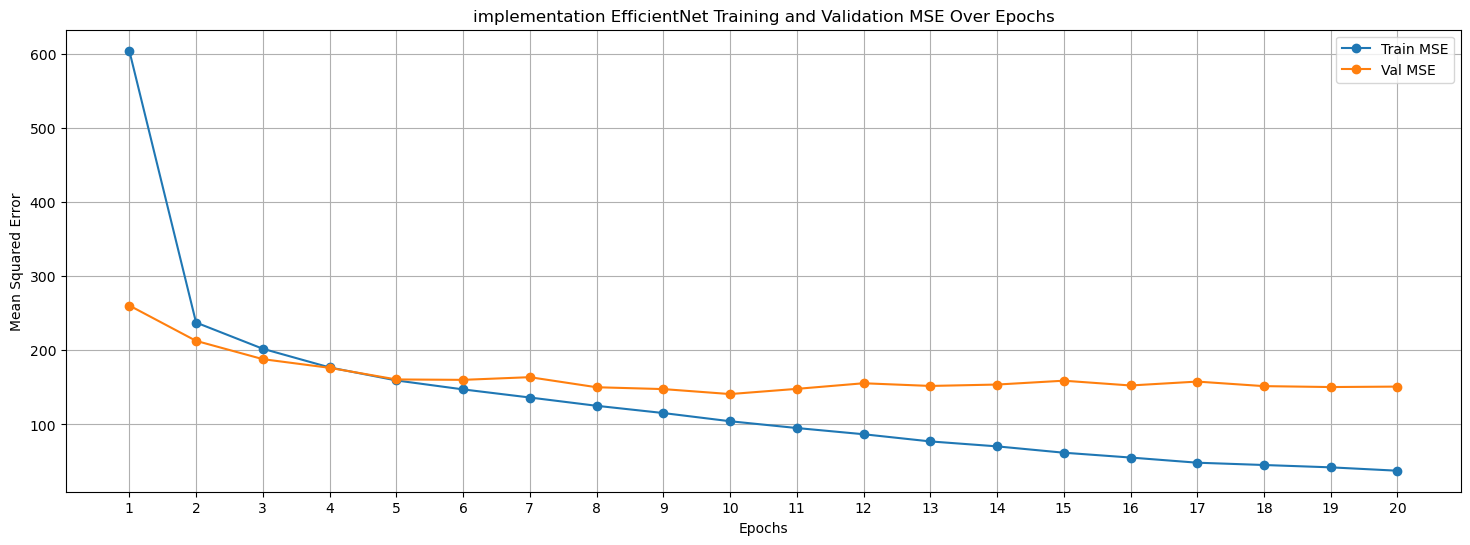

In [99]:
display_implementation_results('implementation EfficientNet.txt')

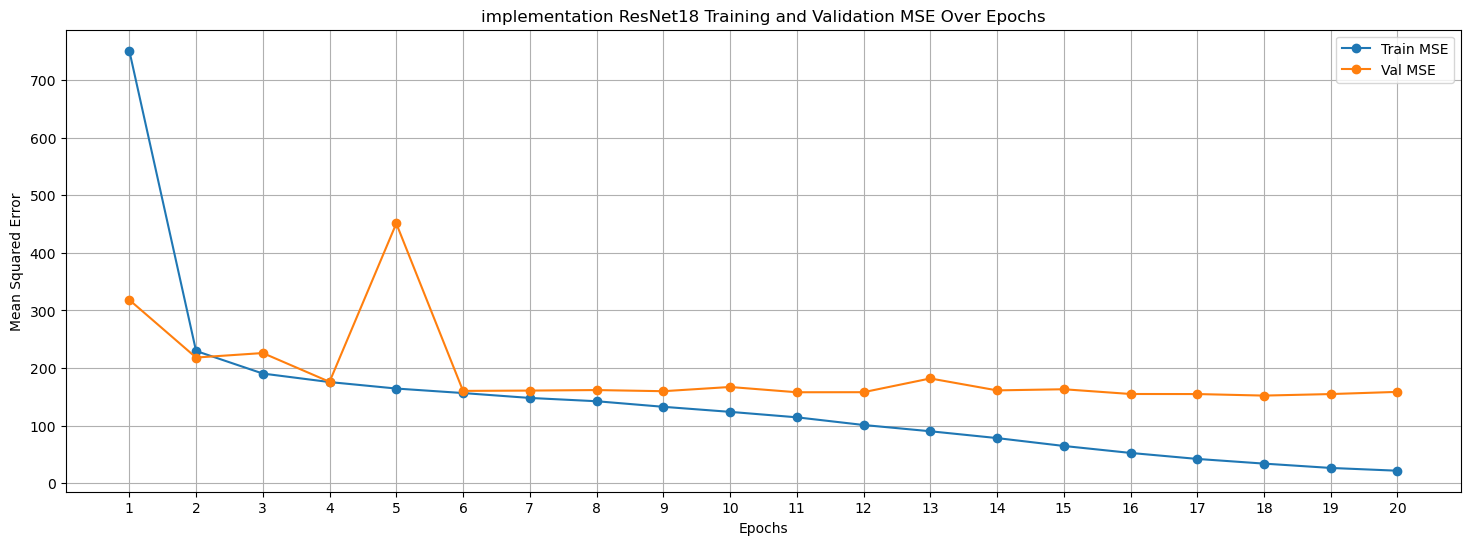

In [100]:
display_implementation_results('implementation ResNet18.txt')

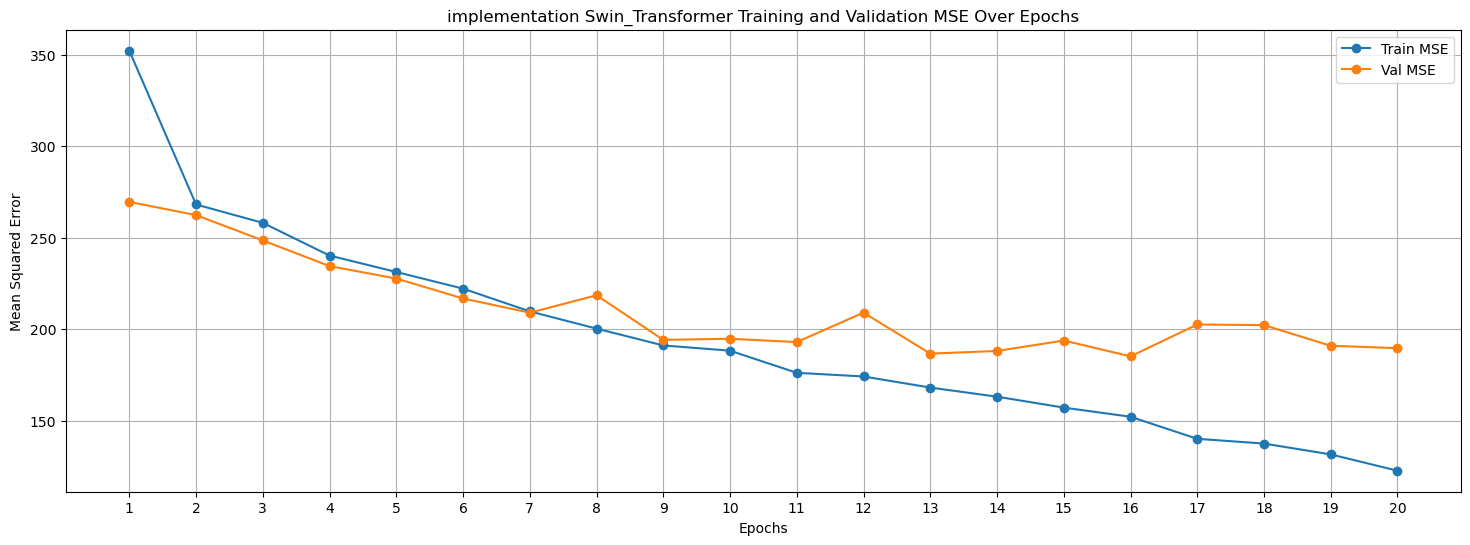

In [101]:
display_implementation_results('implementation Swin_Transformer.txt')

## Hyperparameter fine-tuning evaluation

In [3]:
def read_log_file(file_path, lr):
    sgd_epoch     = []
    sgd_val_mse   = []

    adam_epoch    = []
    adam_val_mse  = []

    adamw_epoch   = []
    adamw_val_mse = []

    with open(file_path, 'r') as f:
        lines = f.readlines()
        
        for line in lines:
            match = re.search(r'\{.*?\}, Epoch \[(\d+)/\d+\], Train MSE: [\d.]+, Average batch train mse: [\d.]+, Val MSE: ([\d.]+)', line)
            if match:
                epoch = int(match.group(1))
                val_mse = float(match.group(2))

                if str(lr) in line:
                    if 'SGD' in line:
                        sgd_epoch.append(epoch)
                        sgd_val_mse.append(val_mse)
                    elif 'AdamW' in line:
                        adamw_epoch.append(epoch)
                        adamw_val_mse.append(val_mse)
                    elif 'Adam' in line:
                        adam_epoch.append(epoch)
                        adam_val_mse.append(val_mse)

    return sgd_val_mse, sgd_epoch, adam_val_mse, adam_epoch, adamw_val_mse, adamw_epoch

def display_fine_tuning_evaluation(file_path):
    sgd_val_001, sgd_epoch_001, adam_val_001, adam_epoch_001, adamw_val_001, adamw_epoch_001 = read_log_file(file_path, lr=0.001)
    sgd_val_0001, sgd_epoch_0001, adam_val_0001, adam_epoch_0001, adamw_val_0001, adamw_epoch_0001 = read_log_file(file_path, lr=0.0001)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    ax1.plot(sgd_epoch_001, sgd_val_001, label='SGD Val MSE (0.001)', marker='o')
    ax1.plot(adam_epoch_001, adam_val_001, label='Adam Val MSE (0.001)', marker='o')
    ax1.plot(adamw_epoch_001, adamw_val_001, label='AdamW Val MSE (0.001)', marker='o')
    ax1.set_title('Validation MSE Comparison for Different Optimizers in 0.001 Learning Rate')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Validation MSE')
    ax1.legend()
    ax1.grid()

    ax2.plot(sgd_epoch_0001, sgd_val_0001, label='SGD Val MSE (0.0001)', marker='o')
    ax2.plot(adam_epoch_0001, adam_val_0001, label='Adam Val MSE (0.0001)', marker='o')
    ax2.plot(adamw_epoch_0001, adamw_val_0001, label='AdamW Val MSE (0.0001)', marker='o')
    ax2.set_title('Validation MSE Comparison for Different Optimizers in 0.0001 Learning Rate')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Validation MSE')
    ax2.legend()
    ax2.grid()

    plt.tight_layout()
    plt.show()



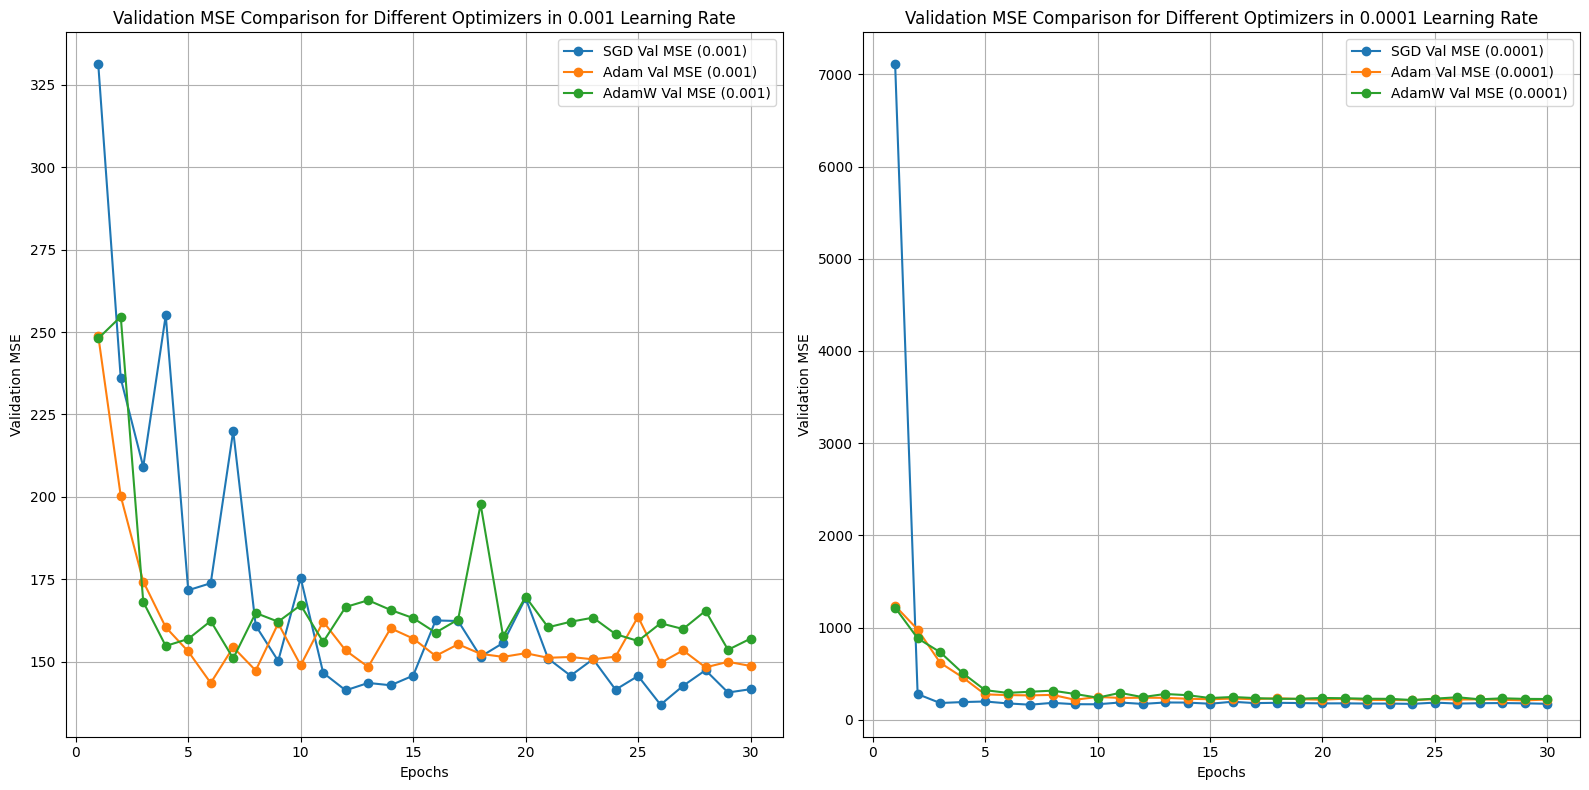

In [4]:
display_fine_tuning_evaluation('efficientModel_results.txt')

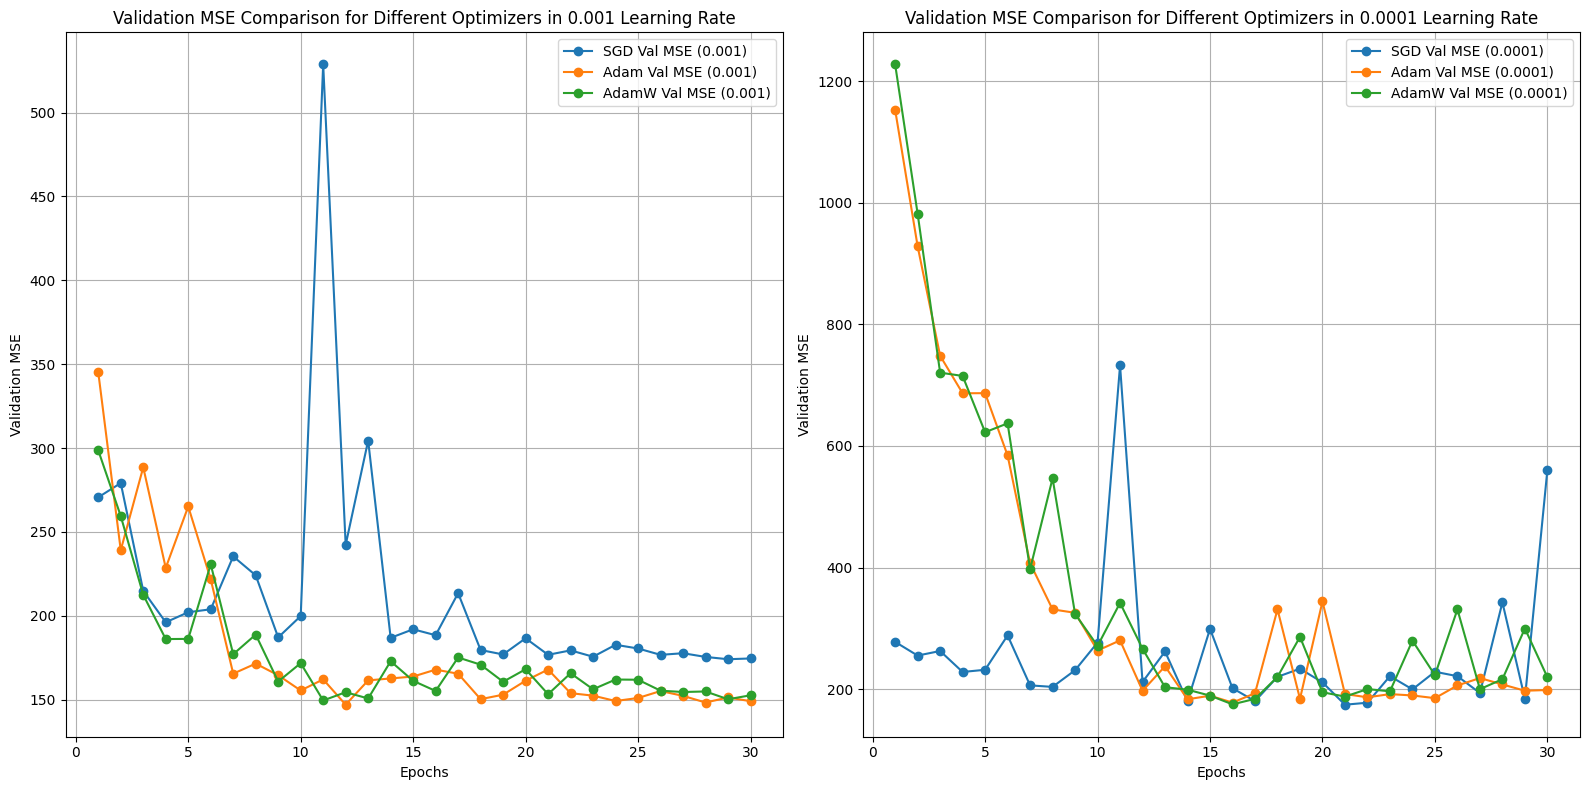

In [5]:
display_fine_tuning_evaluation('resnetModel_results.txt')

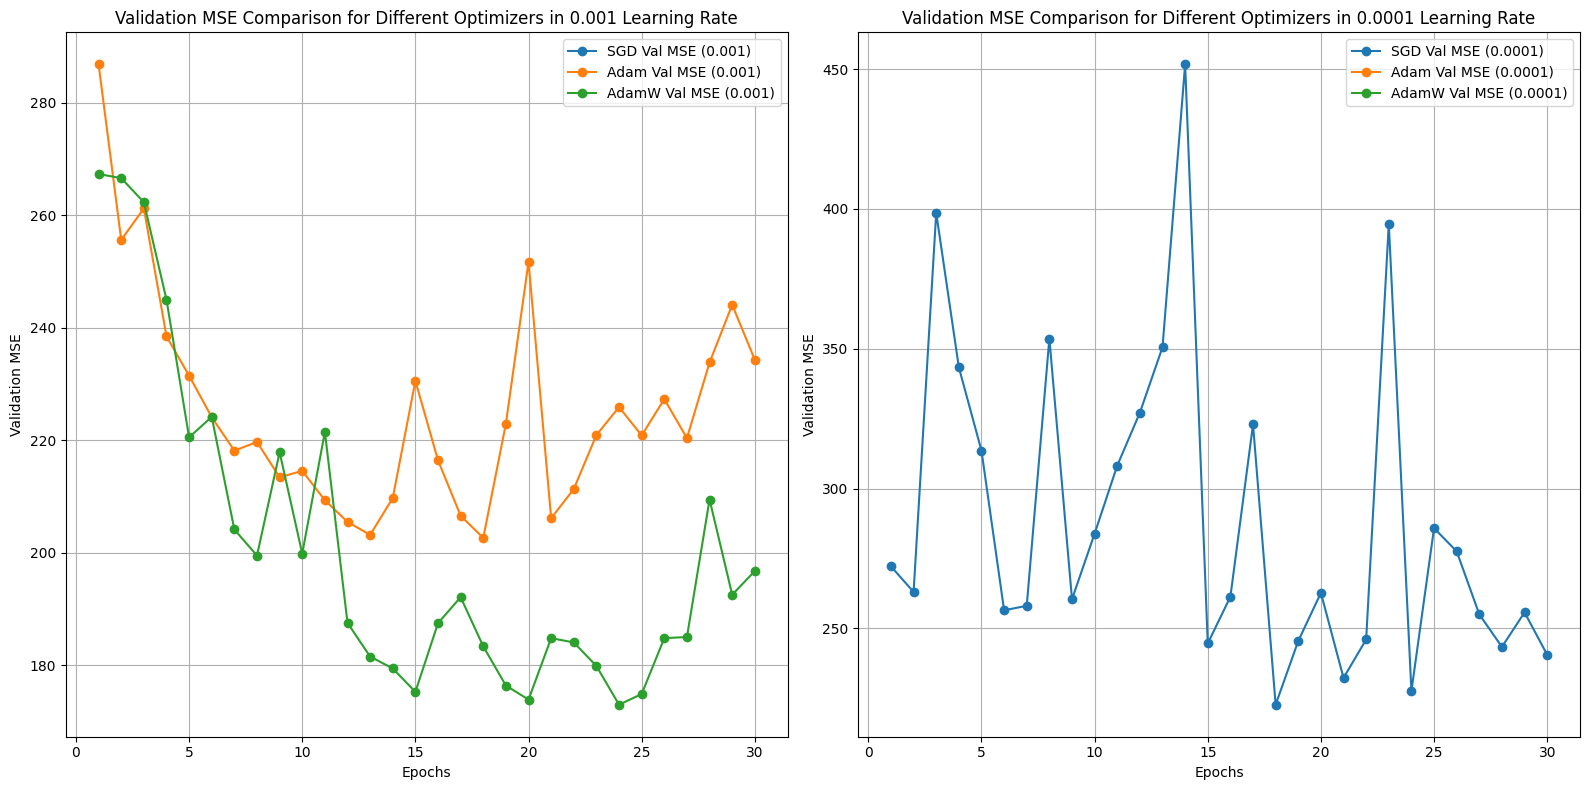

In [6]:
display_fine_tuning_evaluation('swinModel_results.txt')

### Comparison

In [49]:
resNet18_test_mse = 147
efficientNet_test_mse = 134.0081
swin_test_mse = 178.9268

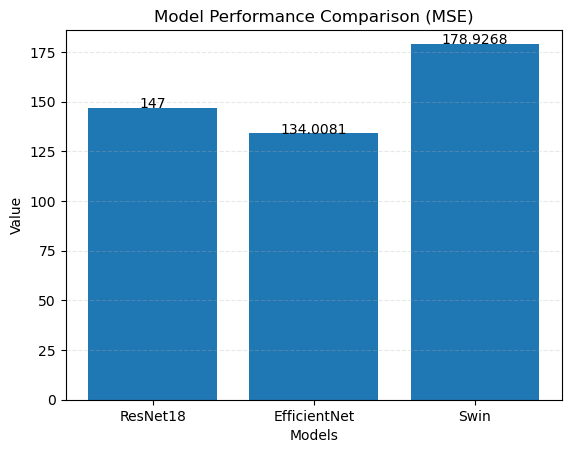

In [51]:
def display_evaluation(resNet18, efficientNet, swin, title):
    models = ['ResNet18', 'EfficientNet', 'Swin']
    values = [resNet18, efficientNet, swin]
    
    plt.bar(np.arange(len(models)), values)
    
    plt.title(title)
    plt.xlabel('Models')
    plt.ylabel('Value')
    plt.xticks(np.arange(len(models)), models)
    
    for i, value in enumerate(values):
        plt.text(i, value, str(value), ha='center')
    
    plt.ylim(0, max(values) + 7)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.show()

display_evaluation(resNet18_test_mse, efficientNet_test_mse, swin_test_mse, 'Model Performance Comparison (MSE)')

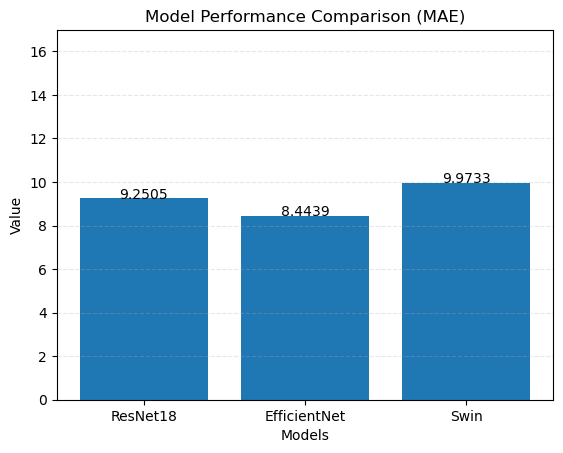

In [56]:
resNet18_test_mae = 9.2505
efficientNet_test_mae = 8.4439
swin_test_mae = 9.9733
display_evaluation(resNet18_test_mae, efficientNet_test_mae, swin_test_mae, 'Model Performance Comparison (MAE)')

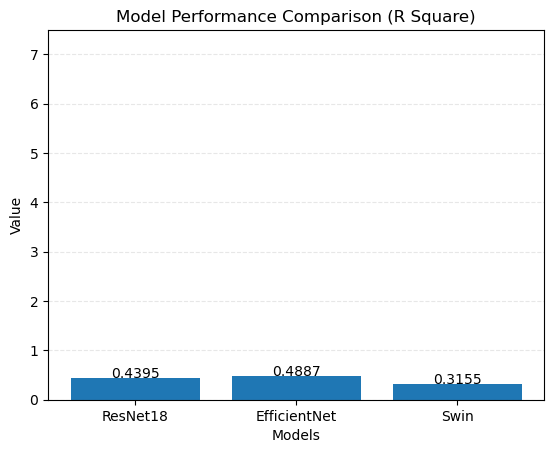

In [61]:
resNet18_test_R_square = 0.4395
efficientNet_test_R_square = 0.4887
swin_test_R_square = 0.3155
display_evaluation(resNet18_test_R_square, efficientNet_test_R_square, swin_test_R_square, 'Model Performance Comparison (R Square)')

# 6. Final models

In [62]:
efficientModel = EfficientNet()
file_path = 'efficientModel.pth'

if os.path.exists(file_path):
    checkpoint = torch.load(file_path)
    efficientModel.load_state_dict(checkpoint['model_state_dict'])
else:
    efficientModel = training_model(efficientModel, device, 'AdamW', 0.0001, 30, train_dataset, val_dataset, test_dataset, 128)
    torch.save({'model_state_dict': efficientModel.state_dict()}, file_path)  

efficientModel.to(device)
criterion = torch.nn.MSELoss()
test_mse, avg_batch_test_loss = test(efficientModel, test_dataset, 128, device, criterion)

C:\Users\nizeyu\AppData\Local\Temp\ipykernel_39276\1111358782.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)


Mon Oct 14 23:53:20 2024, Test MSE: 133.6253, Average batch Test loss: 134.0081


In [63]:
resnetModel = ResNet18()
file_path = 'resnetModel.pth'

if os.path.exists(file_path):
    checkpoint = torch.load(file_path)
    resnetModel.load_state_dict(checkpoint['model_state_dict'])
else:
    resnetModel = training_model(resnetModel, device, 'Adam', 0.001, 30, train_dataset, val_dataset, test_dataset, 512)
    torch.save({'model_state_dict': resnetModel.state_dict()}, file_path)  
    
resnetModel.to(device)
criterion = torch.nn.MSELoss()
test_mse, avg_batch_test_loss = test(resnetModel, test_dataset, 512, device, criterion)

C:\Users\nizeyu\AppData\Local\Temp\ipykernel_39276\3208935153.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)


Mon Oct 14 23:53:50 2024, Test MSE: 146.4857, Average batch Test loss: 146.7231


In [64]:
swinModel = SwinTransformerWithMLP()
file_path = 'swinModel.pth'

if os.path.exists(file_path):
    checkpoint = torch.load(file_path)
    swinModel.load_state_dict(checkpoint['model_state_dict'])
#else:
#    swinModel = training_model(swinModel, device, 'AdamW', 0.001, 30, train_dataset, val_dataset, test_dataset, 64)
#    torch.save({'model_state_dict': swinModel.state_dict()}, file_path)  
    
swinModel.to(device)
criterion = torch.nn.MSELoss()
test_mse, avg_batch_test_loss = test(swinModel, test_dataset, 512, device, criterion)

C:\Users\nizeyu\AppData\Local\Temp\ipykernel_39276\3131243850.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)


Mon Oct 14 23:54:12 2024, Test MSE: 178.8896, Average batch Test loss: 178.9268
